In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


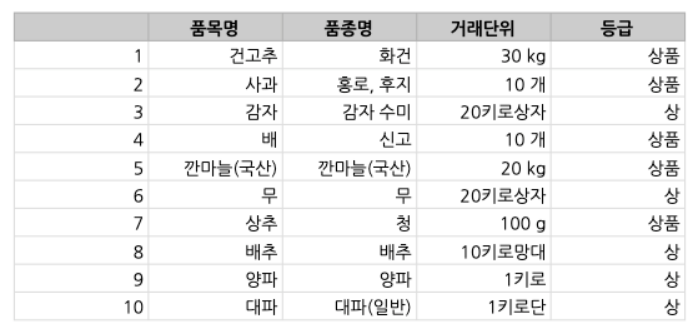

# Import Library

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from types import SimpleNamespace
from sklearn.preprocessing import MinMaxScaler
import os
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

## seed

In [ ]:
data_path = '/content/drive/MyDrive/SAI/Project/open'

train_df = pd.read_csv(data_path + '/train/train.csv')
sub_df = pd.read_csv(data_path + '/sample_submission.csv')

## 베이스라인 코드에서 정규화빼고 가져옴

In [ ]:
품목_리스트 = ['건고추', '사과', '감자', '배', '깐마늘(국산)', '무', '상추', '배추', '양파', '대파']
def process_data(raw_file, 산지공판장_file, 전국도매_file, 품목명, scaler=None):
    raw_data = pd.read_csv(raw_file)
    산지공판장 = pd.read_csv(산지공판장_file)
    전국도매 = pd.read_csv(전국도매_file)

    # 타겟 및 메타데이터 필터 조건 정의
    conditions = {
    '감자': {
        'target': lambda df: (df['품종명'] == '감자 수미') & (df['거래단위'] == '20키로상자') & (df['등급'] == '상'),
        '공판장': {'공판장명': ['*전국농협공판장'], '품목명': ['감자'], '품종명': ['수미'], '등급명': ['상']},
        '도매': {'시장명': ['*전국도매시장'], '품목명': ['감자'], '품종명': ['수미']}
    },
    '건고추': {
        'target': lambda df: (df['품종명'] == '화건') & (df['거래단위'] == '30 kg') & (df['등급'] == '상품'),
        '공판장': None,
        '도매': None
    },
    '깐마늘(국산)': {
        'target': lambda df: (df['거래단위'] == '20 kg') & (df['등급'] == '상품'),
        '공판장': {'공판장명': ['*전국농협공판장'], '품목명': ['마늘'], '품종명': ['깐마늘'], '등급명': ['상']},
        '도매': {'시장명': ['*전국도매시장'], '품목명': ['마늘'], '품종명': ['깐마늘']}
    },
    '대파': {
        'target': lambda df: (df['품종명'] == '대파(일반)') & (df['거래단위'] == '1키로단') & (df['등급'] == '상'),
        '공판장': {'공판장명': ['*전국농협공판장'], '품목명': ['대파'], '품종명': ['대파(일반)'], '등급명': ['상']},
        '도매': {'시장명': ['*전국도매시장'], '품목명': ['대파'], '품종명': ['대파(일반)']}
    },
    '무': {
        'target': lambda df: (df['거래단위'] == '20키로상자') & (df['등급'] == '상'),
        '공판장': {'공판장명': ['*전국농협공판장'], '품목명': ['무'], '품종명': ['기타무'], '등급명': ['상']},
        '도매': {'시장명': ['*전국도매시장'], '품목명': ['무'], '품종명': ['무']}
    },
    '배추': {
        'target': lambda df: (df['거래단위'] == '10키로망대') & (df['등급'] == '상'),
        '공판장': {'공판장명': ['*전국농협공판장'], '품목명': ['배추'], '품종명': ['쌈배추'], '등급명': ['상']},
        '도매': {'시장명': ['*전국도매시장'], '품목명': ['배추'], '품종명': ['배추']}
    },
    '사과': {
        'target': lambda df: (df['품종명'].isin(['홍로', '후지'])) & (df['거래단위'] == '10 개') & (df['등급'] == '상품'),
        '공판장': {'공판장명': ['*전국농협공판장'], '품목명': ['사과'], '품종명': ['후지'], '등급명': ['상']},
        '도매': {'시장명': ['*전국도매시장'], '품목명': ['사과'], '품종명': ['후지']}
    },
    '상추': {
        'target': lambda df: (df['품종명'] == '청') & (df['거래단위'] == '100 g') & (df['등급'] == '상품'),
        '공판장': {'공판장명': ['*전국농협공판장'], '품목명': ['상추'], '품종명': ['청상추'], '등급명': ['상']},
        '도매': {'시장명': ['*전국도매시장'], '품목명': ['상추'], '품종명': ['청상추']}
    },
    '양파': {
        'target': lambda df: (df['품종명'] == '양파') & (df['거래단위'] == '1키로') & (df['등급'] == '상'),
        '공판장': {'공판장명': ['*전국농협공판장'], '품목명': ['양파'], '품종명': ['기타양파'], '등급명': ['상']},
        '도매': {'시장명': ['*전국도매시장'], '품목명': ['양파'], '품종명': ['양파(일반)']}
    },
    '배': {
        'target': lambda df: (df['품종명'] == '신고') & (df['거래단위'] == '10 개') & (df['등급'] == '상품'),
        '공판장': {'공판장명': ['*전국농협공판장'], '품목명': ['배'], '품종명': ['신고'], '등급명': ['상']},
        '도매': {'시장명': ['*전국도매시장'], '품목명': ['배'], '품종명': ['신고']}
    }
    }

    # 타겟 데이터 필터링
    raw_품목 = raw_data[raw_data['품목명'] == 품목명]
    target_mask = conditions[품목명]['target'](raw_품목)
    filtered_data = raw_품목[target_mask]

    # 공판장 데이터 처리
    if conditions[품목명]['공판장']:
        filtered_공판장 = 산지공판장
        for key, value in conditions[품목명]['공판장'].items():
            filtered_공판장 = filtered_공판장[filtered_공판장[key].isin(value)]

        filtered_공판장 = filtered_공판장.add_prefix('공판장_').rename(columns={'공판장_시점': '시점'})
        filtered_data = filtered_data.merge(filtered_공판장, on='시점', how='left')

    # 도매 데이터 처리
    if conditions[품목명]['도매']:
        filtered_도매 = 전국도매
        for key, value in conditions[품목명]['도매'].items():
            filtered_도매 = filtered_도매[filtered_도매[key].isin(value)]

        filtered_도매 = filtered_도매.add_prefix('도매_').rename(columns={'도매_시점': '시점'})
        filtered_data = filtered_data.merge(filtered_도매, on='시점', how='left')

    # 수치형 컬럼 처리
    numeric_columns = filtered_data.select_dtypes(include=[np.number]).columns
    filtered_data = filtered_data[['시점'] + list(numeric_columns)]
    filtered_data[numeric_columns] = filtered_data[numeric_columns].fillna(0)

    return filtered_data, scaler


In [ ]:
품목별_train_data = {}  # 품목별로 train 데이터를 저장할 딕셔너리
품목별_scalers = {}     # 품목별로 스케일러를 저장할 딕셔너리
data_path = '/content/drive/MyDrive/SAI/Project/open'

pbar_outer = tqdm(품목_리스트, desc="품목 처리 중", position=0)
for 품목명 in pbar_outer:
    pbar_outer.set_description(f"품목별 전처리 및 모델 학습 -> {품목명}")

    # 각 품목에 대해 데이터 전처리 및 스케일러 저장
    train_data, scaler = process_data(
        data_path + "/train/train.csv",
        data_path + "/train/meta/TRAIN_산지공판장_2018-2021.csv",
        data_path + "/train/meta/TRAIN_전국도매_2018-2021.csv",
        품목명
    )

    # 품목별 train_data와 scaler를 각각 저장
    품목별_train_data[품목명] = train_data
    품목별_scalers[품목명] = scaler


품목 처리 중:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
품목별_train_data

{'건고추':            시점     평년 평균가격(원)   평균가격(원)
 0    201801상순  381666.666667  590000.0
 1    201801중순  380809.666667  590000.0
 2    201801하순  380000.000000  590000.0
 3    201802상순  380000.000000  590000.0
 4    201802중순  376666.666667  590000.0
 ..        ...            ...       ...
 139  202111중순  552944.333333  558000.0
 140  202111하순  554071.333333  565143.0
 141  202112상순  559000.000000  570500.0
 142  202112중순  552000.000000  570500.0
 143  202112하순  540555.333333  560778.0
 
 [144 rows x 3 columns],
 '사과':            시점    평년 평균가격(원)  평균가격(원)     공판장_공판장코드  공판장_품목코드  공판장_품종코드  \
 0    201801상순  21461.666667  20361.0  1.000000e+09     601.0   60103.0   
 1    201801중순  22179.666667  20359.0  1.000000e+09     601.0   60103.0   
 2    201801하순  22917.666667  20653.0  1.000000e+09     601.0   60103.0   
 3    201802상순  23424.666667  20563.0  1.000000e+09     601.0   60103.0   
 4    201802중순  23201.666667  21779.0  1.000000e+09     601.0   60103.0   
 ..        ...           ...  

## 테스트 파일

In [ ]:
품목별_test_data = {}  # 품목별로 train 데이터를 저장할 딕셔너리
품목별_test_scalers = {}     # 품목별로 스케일러를 저장할 딕셔너리

In [ ]:
pbar_outer = tqdm(품목_리스트, desc="품목 처리 중", position=0)
i=0
for 품목명 in pbar_outer:
    pbar_outer.set_description(f"품목별 전처리 및 모델 학습 -> {품목명}")

    # 각 품목에 대해 데이터 전처리 및 스케일러 저장
    # 'test_file', '산지공판장_file', '전국도매_file'를 위치 인수로 전달
    test_data, scaler = process_data(
        data_path + f"/test/TEST_{i:02d}.csv", # 위치 인수로 변경
        data_path + f"/test/meta/TEST_산지공판장_{i:02d}.csv", # 위치 인수로 변경
        data_path + f"/test/meta/TEST_전국도매_{i:02d}.csv",  # 위치 인수로 변경
        품목명
    )
    i = i+1

    # 품목별 train_data와 scaler를 각각 저장
    품목별_test_data[품목명] = train_data
    품목별_test_scalers[품목명] = scaler

품목 처리 중:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
품목별_test_data

{'건고추':            시점   평년 평균가격(원)      평균가격(원)     공판장_공판장코드  공판장_품목코드  공판장_품종코드  \
 0    201801상순  1620.029101  1685.285714  1.000000e+09    1202.0  120201.0   
 1    201801중순  1422.509259  1624.888889  1.000000e+09    1202.0  120201.0   
 2    201801하순  1520.266667  1834.333333  1.000000e+09    1202.0  120201.0   
 3    201802상순  1793.421296  2530.111111  1.000000e+09    1202.0  120201.0   
 4    201802중순  1977.732143  1537.833333  1.000000e+09    1202.0  120201.0   
 ..        ...          ...          ...           ...       ...       ...   
 139  202111중순  1934.819444  1754.222222  1.000000e+09    1202.0  120201.0   
 140  202111하순  1774.898148  1460.250000  1.000000e+09    1202.0  120201.0   
 141  202112상순  1728.379630  1619.000000  1.000000e+09    1202.0  120201.0   
 142  202112중순  1677.643519  1217.125000  1.000000e+09    1202.0  120201.0   
 143  202112하순  1581.411111  1322.200000  1.000000e+09    1202.0  120201.0   
 
      공판장_등급코드  공판장_총반입량(kg)  공판장_총거래금액(원)  공판장_평균가(원/k

In [ ]:
drop_col =['시점','공판장_공판장코드', '공판장_품목코드', '공판장_품종코드', '공판장_등급코드', '도매_시장코드', '도매_품목코드', '도매_품종코드']
drop_col2 =['시점','공판장_공판장코드', '공판장_품목코드', '공판장_품종코드', '공판장_등급코드', '도매_시장코드', '도매_품목코드', '도매_품종코드']

In [ ]:
for 품목명 in 품목_리스트:
    # Get the columns of the current DataFrame
    existing_columns = 품목별_test_data[품목명].columns

    # Find the columns to drop that actually exist in the DataFrame
    cols_to_drop = [col for col in drop_col if col in existing_columns]

    # Drop only the existing columns
    품목별_test_data[품목명].drop(cols_to_drop, inplace=True, axis=1)

In [ ]:
품목별_test_data['배추']

,평년 평균가격(원),평균가격(원),공판장_총반입량(kg),공판장_총거래금액(원),공판장_평균가(원/kg),공판장_중간가(원/kg),공판장_최저가(원/kg),공판장_최고가(원/kg),공판장_경매 건수,공판장_전순 평균가격(원) PreVious SOON,...,도매_저가(20%) 평균가,도매_중간가(원/kg),도매_최저가(원/kg),도매_최고가(원/kg),도매_경매 건수,도매_전순 평균가격(원) PreVious SOON,도매_전달 평균가격(원) PreVious MMonth,도매_전년 평균가격(원) PreVious YeaR,도매_평년 평균가격(원) Common Year SOON,도매_연도
0,1620.029101,1685.285714,138.0,64300.0,465.942029,500.000000,375.000000,553.846154,5.0,426.470588,...,928.820940,1400.000000,0.0,12000.000000,2378,2683.460539,9595.902402,3964.009533,11133.735966,2018
1,1422.509259,1624.888889,128.0,81000.0,632.812500,625.000000,500.000000,750.000000,3.0,465.942029,...,1010.670280,1460.000000,0.0,12190.000000,2641,1413.419669,2746.309547,3559.376068,11806.966713,2018
2,1520.266667,1834.333333,10.0,9000.0,900.000000,900.000000,900.000000,900.000000,1.0,632.812500,...,953.370036,1500.000000,0.0,15000.000000,2705,1402.448110,2683.460539,3659.592928,8459.574531,2018
3,1793.421296,2530.111111,255.0,169800.0,665.882353,677.765805,625.000000,750.000000,4.0,900.000000,...,1439.821871,2200.000000,0.0,16000.000000,3169,1471.817186,1413.419669,3690.061030,13362.709553,2018
4,1977.732143,1537.833333,171.0,259400.0,1516.959064,900.000000,750.000000,1732.824427,3.0,665.882353,...,781.001593,1665.615764,0.0,7738.000000,2002,2162.890905,1402.448110,3336.429133,12421.610415,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1934.819444,1754.222222,290.0,157400.0,542.758621,453.571429,360.169492,937.500000,6.0,607.181572,...,980.897530,1337.083333,0.0,26550.000000,4226,1361.472556,1271.163760,2399.391298,2023.048140,2021
140,1774.898148,1460.250000,656.0,343100.0,523.018293,500.000000,404.545455,692.857143,8.0,542.758621,...,756.762411,1050.000000,0.0,8000.000000,3786,1486.223470,1330.590568,1981.463660,1877.729100,2021
141,1728.379630,1619.000000,990.0,631300.0,637.676768,552.819237,310.000000,883.188406,8.0,523.018293,...,874.836602,1216.393443,0.0,3866.166667,3753,1157.210533,1361.472556,1608.308102,2297.780295,2021
142,1677.643519,1217.125000,320.0,135900.0,424.687500,500.000000,323.076923,750.000000,7.0,637.676768,...,693.569200,987.894737,0.0,6509.500000,3029,1320.617115,1486.223470,1694.464881,1912.584095,2021


In [ ]:
품목별_test_data['배추'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 29 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   평년 평균가격(원)                       144 non-null    float64
 1   평균가격(원)                          144 non-null    float64
 2   공판장_총반입량(kg)                     144 non-null    float64
 3   공판장_총거래금액(원)                     144 non-null    float64
 4   공판장_평균가(원/kg)                    144 non-null    float64
 5   공판장_중간가(원/kg)                    144 non-null    float64
 6   공판장_최저가(원/kg)                    144 non-null    float64
 7   공판장_최고가(원/kg)                    144 non-null    float64
 8   공판장_경매 건수                        144 non-null    float64
 9   공판장_전순 평균가격(원) PreVious SOON     144 non-null    float64
 10  공판장_전달 평균가격(원) PreVious MMonth   144 non-null    float64
 11  공판장_전년 평균가격(원) PreVious YeaR     144 non-null    float64
 12  공판장_평년 평균가격(원) Common 

## 필요없어보이는 컬럼 삭제

test의 시점을 알 수 없어서 그냥 삭제

In [ ]:
for 품목명 in 품목_리스트:
    # Get the columns of the current DataFrame
    existing_columns = 품목별_train_data[품목명].columns
    existing_columns2 = 품목별_test_data[품목명].columns

    # Find the columns to drop that actually exist in the DataFrame
    cols_to_drop = [col for col in drop_col if col in existing_columns]
    cols_to_drop2 = [col for col in drop_col if col in existing_columns2]

    # Drop only the existing columns
    품목별_train_data[품목명].drop(cols_to_drop, inplace=True, axis=1)
    품목별_test_data[품목명].drop(cols_to_drop2, inplace=True, axis=1)

---

In [ ]:
for 품목명 in 품목_리스트:
  print(품목별_train_data[품목명].columns)

Index(['평년 평균가격(원)', '평균가격(원)'], dtype='object')
Index(['평년 평균가격(원)', '평균가격(원)', '공판장_총반입량(kg)', '공판장_총거래금액(원)',
       '공판장_평균가(원/kg)', '공판장_중간가(원/kg)', '공판장_최저가(원/kg)', '공판장_최고가(원/kg)',
       '공판장_경매 건수', '공판장_전순 평균가격(원) PreVious SOON',
       '공판장_전달 평균가격(원) PreVious MMonth', '공판장_전년 평균가격(원) PreVious YeaR',
       '공판장_평년 평균가격(원) Common Year SOON', '공판장_연도', '도매_총반입량(kg)',
       '도매_총거래금액(원)', '도매_평균가(원/kg)', '도매_고가(20%) 평균가', '도매_중가(60%) 평균가 ',
       '도매_저가(20%) 평균가', '도매_중간가(원/kg)', '도매_최저가(원/kg)', '도매_최고가(원/kg)',
       '도매_경매 건수', '도매_전순 평균가격(원) PreVious SOON',
       '도매_전달 평균가격(원) PreVious MMonth', '도매_전년 평균가격(원) PreVious YeaR',
       '도매_평년 평균가격(원) Common Year SOON', '도매_연도'],
      dtype='object')
Index(['평년 평균가격(원)', '평균가격(원)', '공판장_총반입량(kg)', '공판장_총거래금액(원)',
       '공판장_평균가(원/kg)', '공판장_중간가(원/kg)', '공판장_최저가(원/kg)', '공판장_최고가(원/kg)',
       '공판장_경매 건수', '공판장_전순 평균가격(원) PreVious SOON',
       '공판장_전달 평균가격(원) PreVious MMonth', '공판장_전년 평균가격(원) PreVious YeaR',
       '공판장_평년

### 결측치 없음

In [ ]:
for 품목명 in 품목_리스트:
  print(품목별_train_data[품목명].isnull().sum())

평년 평균가격(원)    0
평균가격(원)       0
dtype: int64
평년 평균가격(원)                         0
평균가격(원)                            0
공판장_총반입량(kg)                       0
공판장_총거래금액(원)                       0
공판장_평균가(원/kg)                      0
공판장_중간가(원/kg)                      0
공판장_최저가(원/kg)                      0
공판장_최고가(원/kg)                      0
공판장_경매 건수                          0
공판장_전순 평균가격(원) PreVious SOON       0
공판장_전달 평균가격(원) PreVious MMonth     0
공판장_전년 평균가격(원) PreVious YeaR       0
공판장_평년 평균가격(원) Common Year SOON    0
공판장_연도                             0
도매_총반입량(kg)                        0
도매_총거래금액(원)                        0
도매_평균가(원/kg)                       0
도매_고가(20%) 평균가                     0
도매_중가(60%) 평균가                     0
도매_저가(20%) 평균가                     0
도매_중간가(원/kg)                       0
도매_최저가(원/kg)                       0
도매_최고가(원/kg)                       0
도매_경매 건수                           0
도매_전순 평균가격(원) PreVious SOON        0
도매_전달 평균가격(원) PreVious MMonth 

## 1.건고추

In [ ]:
품목별_train_data['건고추']

,평년 평균가격(원),평균가격(원)
0,381666.666667,590000.0
1,380809.666667,590000.0
2,380000.000000,590000.0
3,380000.000000,590000.0
4,376666.666667,590000.0
...,...,...
139,552944.333333,558000.0
140,554071.333333,565143.0
141,559000.000000,570500.0
142,552000.000000,570500.0


건고추는 컬럼이 특별히 없다

In [ ]:
품목별_train_data['건고추']['평균가격(원)'][품목별_train_data['건고추']['평균가격(원)'] == 0]

,평균가격(원)


## 2.사과

In [ ]:
품목별_train_data['사과']

,평년 평균가격(원),평균가격(원),공판장_총반입량(kg),공판장_총거래금액(원),공판장_평균가(원/kg),공판장_중간가(원/kg),공판장_최저가(원/kg),공판장_최고가(원/kg),공판장_경매 건수,공판장_전순 평균가격(원) PreVious SOON,...,도매_저가(20%) 평균가,도매_중간가(원/kg),도매_최저가(원/kg),도매_최고가(원/kg),도매_경매 건수,도매_전순 평균가격(원) PreVious SOON,도매_전달 평균가격(원) PreVious MMonth,도매_전년 평균가격(원) PreVious YeaR,도매_평년 평균가격(원) Common Year SOON,도매_연도
0,21461.666667,20361.0,30029.0,38987900.0,1298.341603,1312.490667,1175.258126,1788.029079,8.0,1260.442271,...,940.431303,1567.500000,160.0,6750.000000,4983,20489.828672,19563.378717,21379.550547,29947.583478,2018
1,22179.666667,20359.0,32850.0,47178650.0,1436.184170,1411.928224,1145.856354,2476.470588,10.0,1298.341603,...,971.136232,1568.422619,0.0,7500.000000,6654,1821.996777,20205.542523,17569.642828,29135.949332,2018
2,22917.666667,20653.0,56083.0,92952000.0,1657.400638,1479.068229,1257.142857,1945.912617,10.0,1436.184170,...,1000.965417,1650.000000,0.0,8750.000000,6754,1814.745669,20489.828672,17899.590723,27226.186456,2018
3,23424.666667,20563.0,70301.0,130083200.0,1850.374817,1861.558138,1363.274131,4342.105263,10.0,1657.400638,...,1575.373564,2408.816425,0.0,8600.000000,11881,2158.150110,1821.996777,32354.422468,29369.216581,2018
4,23201.666667,21779.0,15305.0,28780900.0,1880.490036,2017.522898,1341.500000,3317.777778,6.0,1850.374817,...,1489.307364,2333.333333,0.0,6631.683168,1916,3058.557320,1814.745669,21564.150518,25992.665817,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,20743.666667,26004.0,51344.0,101363400.0,1974.201465,2009.959623,1822.500000,2088.489968,7.0,2045.418565,...,1187.437138,1850.000000,0.0,480000.000000,4322,2193.229976,3348.720561,2349.090908,7631.722587,2021
140,20673.000000,25494.0,55760.0,99156500.0,1778.272956,1775.360657,1251.923077,2280.000000,10.0,1974.201465,...,1020.127185,1728.571429,0.0,13888.888889,4027,2145.942355,2642.083217,2586.391320,7682.896887,2021
141,20539.666667,26144.0,41488.0,80457500.0,1939.295700,1989.797268,1484.852941,2196.363636,9.0,1778.272956,...,1193.492843,1830.000000,0.0,11666.666667,533,2046.859486,2193.229976,2887.419898,8128.827890,2021
142,20197.000000,26177.0,38256.0,75728400.0,1979.516939,1962.400412,1427.172775,2454.724638,10.0,1939.295700,...,1086.821849,1746.296296,200.0,11666.666667,3469,2189.240787,2145.942355,2972.201945,8241.307901,2021


In [ ]:
품목별_train_data['사과']['도매_최고가(원/kg)'].value_counts()

,count
도매_최고가(원/kg),
11666.666667,6
10000.000000,4
12000.000000,4
7500.000000,4
6000.000000,4
...,...
6096.000000,1
9550.000000,1
7552.289157,1


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE GYEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


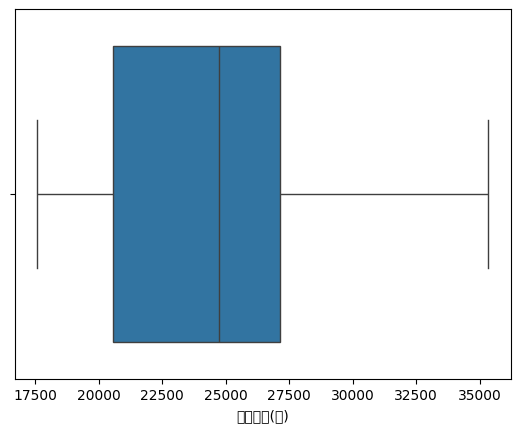

In [ ]:
sns.boxplot(x = "평균가격(원)", data = 품목별_train_data['사과'])
plt.show()

In [ ]:
# 각 column 별로 0인 셀들의 갯수를 계산합니다.
zeros_per_column = (품목별_train_data['사과'] == 0).sum()
print(zeros_per_column)

평년 평균가격(원)                           5
평균가격(원)                              0
공판장_총반입량(kg)                        11
공판장_총거래금액(원)                        11
공판장_평균가(원/kg)                       11
공판장_중간가(원/kg)                       11
공판장_최저가(원/kg)                       11
공판장_최고가(원/kg)                       11
공판장_경매 건수                           11
공판장_전순 평균가격(원) PreVious SOON        15
공판장_전달 평균가격(원) PreVious MMonth      21
공판장_전년 평균가격(원) PreVious YeaR        14
공판장_평년 평균가격(원) Common Year SOON    112
공판장_연도                              11
도매_총반입량(kg)                          0
도매_총거래금액(원)                          0
도매_평균가(원/kg)                         0
도매_고가(20%) 평균가                       0
도매_중가(60%) 평균가                       0
도매_저가(20%) 평균가                       0
도매_중간가(원/kg)                         0
도매_최저가(원/kg)                       113
도매_최고가(원/kg)                         0
도매_경매 건수                             0
도매_전순 평균가격(원) PreVious SOON          0
도매_전달 평균가격(원) PreVious MM

In [ ]:
품목별_train_data['사과'].drop(['공판장_평년 평균가격(원) Common Year SOON', '도매_최저가(원/kg)'], inplace=True, axis=1)
품목별_test_data['사과'].drop(['공판장_평년 평균가격(원) Common Year SOON', '도매_최저가(원/kg)'], inplace=True, axis=1)

In [ ]:
품목별_train_data['사과']

,평년 평균가격(원),평균가격(원),공판장_총반입량(kg),공판장_총거래금액(원),공판장_평균가(원/kg),공판장_중간가(원/kg),공판장_최저가(원/kg),공판장_최고가(원/kg),공판장_경매 건수,공판장_전순 평균가격(원) PreVious SOON,...,도매_중가(60%) 평균가,도매_저가(20%) 평균가,도매_중간가(원/kg),도매_최고가(원/kg),도매_경매 건수,도매_전순 평균가격(원) PreVious SOON,도매_전달 평균가격(원) PreVious MMonth,도매_전년 평균가격(원) PreVious YeaR,도매_평년 평균가격(원) Common Year SOON,도매_연도
0,21461.666667,20361.0,30029.0,38987900.0,1298.341603,1312.490667,1175.258126,1788.029079,8.0,1260.442271,...,1757.079788,940.431303,1567.500000,6750.000000,4983,20489.828672,19563.378717,21379.550547,29947.583478,2018
1,22179.666667,20359.0,32850.0,47178650.0,1436.184170,1411.928224,1145.856354,2476.470588,10.0,1298.341603,...,1738.929535,971.136232,1568.422619,7500.000000,6654,1821.996777,20205.542523,17569.642828,29135.949332,2018
2,22917.666667,20653.0,56083.0,92952000.0,1657.400638,1479.068229,1257.142857,1945.912617,10.0,1436.184170,...,1988.631866,1000.965417,1650.000000,8750.000000,6754,1814.745669,20489.828672,17899.590723,27226.186456,2018
3,23424.666667,20563.0,70301.0,130083200.0,1850.374817,1861.558138,1363.274131,4342.105263,10.0,1657.400638,...,3090.563493,1575.373564,2408.816425,8600.000000,11881,2158.150110,1821.996777,32354.422468,29369.216581,2018
4,23201.666667,21779.0,15305.0,28780900.0,1880.490036,2017.522898,1341.500000,3317.777778,6.0,1850.374817,...,2629.047661,1489.307364,2333.333333,6631.683168,1916,3058.557320,1814.745669,21564.150518,25992.665817,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,20743.666667,26004.0,51344.0,101363400.0,1974.201465,2009.959623,1822.500000,2088.489968,7.0,2045.418565,...,2073.942903,1187.437138,1850.000000,480000.000000,4322,2193.229976,3348.720561,2349.090908,7631.722587,2021
140,20673.000000,25494.0,55760.0,99156500.0,1778.272956,1775.360657,1251.923077,2280.000000,10.0,1974.201465,...,1950.270989,1020.127185,1728.571429,13888.888889,4027,2145.942355,2642.083217,2586.391320,7682.896887,2021
141,20539.666667,26144.0,41488.0,80457500.0,1939.295700,1989.797268,1484.852941,2196.363636,9.0,1778.272956,...,2108.958356,1193.492843,1830.000000,11666.666667,533,2046.859486,2193.229976,2887.419898,8128.827890,2021
142,20197.000000,26177.0,38256.0,75728400.0,1979.516939,1962.400412,1427.172775,2454.724638,10.0,1939.295700,...,2086.761087,1086.821849,1746.296296,11666.666667,3469,2189.240787,2145.942355,2972.201945,8241.307901,2021


## 3.감자

In [ ]:
품목별_train_data['감자']

,평년 평균가격(원),평균가격(원),공판장_총반입량(kg),공판장_총거래금액(원),공판장_평균가(원/kg),공판장_중간가(원/kg),공판장_최저가(원/kg),공판장_최고가(원/kg),공판장_경매 건수,공판장_전순 평균가격(원) PreVious SOON,...,도매_저가(20%) 평균가,도매_중간가(원/kg),도매_최저가(원/kg),도매_최고가(원/kg),도매_경매 건수,도매_전순 평균가격(원) PreVious SOON,도매_전달 평균가격(원) PreVious MMonth,도매_전년 평균가격(원) PreVious YeaR,도매_평년 평균가격(원) Common Year SOON,도매_연도
0,24660.031746,44170.285714,2900.0,3476100.0,1198.655172,1252.737207,893.055556,1417.857143,4.0,1301.239669,...,867.893389,1261.000000,0.0,9859.633333,1229,168039.623201,27204.818622,22433.563798,18536.038912,2018
1,23299.444444,48283.777778,1710.0,2085800.0,1219.766082,1065.875000,896.865672,1612.941176,6.0,1198.655172,...,919.536882,1395.930233,0.0,7298.233333,1249,1706.113213,352150.152735,21137.201597,17771.978361,2018
2,25218.007407,50243.000000,970.0,1401500.0,1444.845361,1832.000000,1243.382353,2450.000000,3.0,1219.766082,...,1083.501607,1544.090545,0.0,17859.633333,1084,1786.136277,168039.623201,22959.156922,21012.098124,2018
3,28703.875000,55380.666667,9000.0,12978100.0,1442.011111,1187.613636,250.000000,1580.508475,6.0,1444.845361,...,1233.034577,1709.895833,0.0,15087.700000,1341,1891.883725,1706.113213,23072.352424,20698.374644,2018
4,27419.882275,59133.000000,1040.0,1298000.0,1248.076923,1098.214286,475.000000,2100.000000,3.0,1442.011111,...,1082.761975,1812.310606,0.0,5894.733333,639,2150.568635,1786.136277,477075.486339,20440.505199,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,30634.777778,33761.333333,690.0,222000.0,321.739130,345.000000,238.461538,880.000000,4.0,444.112150,...,619.573899,958.888889,0.0,2200.000000,773,1053.997478,1049.192913,903.542378,94155.019504,2021
140,32139.787037,36023.875000,440.0,340300.0,773.409091,760.000000,305.000000,863.750000,3.0,321.739130,...,761.852773,1000.000000,0.0,9000.000000,727,1209.230842,1062.119262,996.452822,7237.309816,2021
141,31688.643519,35233.666667,2520.0,1842600.0,731.190476,765.000000,150.000000,827.500000,7.0,773.409091,...,760.773859,1046.379310,0.0,3257.236842,1033,1333.766848,1053.997478,1030.955996,9934.511788,2021
142,33251.916667,32679.125000,1720.0,925600.0,538.139535,539.202899,223.333333,900.000000,6.0,731.190476,...,687.522864,939.664804,0.0,3150.000000,735,1384.087114,1209.230842,1081.236613,7697.635849,2021


감자 데이터는 '공판장_평년 평균가격(원) Common Year SOON'에 0이 많이 있다.

어떻게 처리할까..

-> 일단 다른 값으로 채워넣었는데 0인 값이 100개가 넘어가는 정도라 그냥 드랍하는게 나을 듯

In [ ]:
# 각 column 별로 0인 셀들의 갯수를 계산합니다.
zeros_per_column = (품목별_train_data['감자'] == 0).sum()
print(zeros_per_column)

평년 평균가격(원)                           0
평균가격(원)                              0
공판장_총반입량(kg)                         2
공판장_총거래금액(원)                         2
공판장_평균가(원/kg)                        2
공판장_중간가(원/kg)                        2
공판장_최저가(원/kg)                        2
공판장_최고가(원/kg)                        2
공판장_경매 건수                            2
공판장_전순 평균가격(원) PreVious SOON         4
공판장_전달 평균가격(원) PreVious MMonth       4
공판장_전년 평균가격(원) PreVious YeaR         4
공판장_평년 평균가격(원) Common Year SOON    110
공판장_연도                               2
도매_총반입량(kg)                          0
도매_총거래금액(원)                          0
도매_평균가(원/kg)                         0
도매_고가(20%) 평균가                       0
도매_중가(60%) 평균가                       0
도매_저가(20%) 평균가                       0
도매_중간가(원/kg)                         0
도매_최저가(원/kg)                       142
도매_최고가(원/kg)                         0
도매_경매 건수                             0
도매_전순 평균가격(원) PreVious SOON          0
도매_전달 평균가격(원) PreVious MM

In [ ]:
품목별_test_data['감자'].columns

Index(['평년 평균가격(원)', '평균가격(원)', '공판장_총반입량(kg)', '공판장_총거래금액(원)',
       '공판장_평균가(원/kg)', '공판장_중간가(원/kg)', '공판장_최저가(원/kg)', '공판장_최고가(원/kg)',
       '공판장_경매 건수', '공판장_전순 평균가격(원) PreVious SOON',
       '공판장_전달 평균가격(원) PreVious MMonth', '공판장_전년 평균가격(원) PreVious YeaR',
       '공판장_연도', '도매_총반입량(kg)', '도매_총거래금액(원)', '도매_평균가(원/kg)',
       '도매_고가(20%) 평균가', '도매_중가(60%) 평균가 ', '도매_저가(20%) 평균가', '도매_중간가(원/kg)',
       '도매_최고가(원/kg)', '도매_경매 건수', '도매_전순 평균가격(원) PreVious SOON',
       '도매_전달 평균가격(원) PreVious MMonth', '도매_전년 평균가격(원) PreVious YeaR',
       '도매_평년 평균가격(원) Common Year SOON', '도매_연도'],
      dtype='object')

In [ ]:
품목별_train_data['감자'].drop(['공판장_평년 평균가격(원) Common Year SOON', '도매_최저가(원/kg)'], inplace=True, axis=1)

In [ ]:
품목별_train_data['감자'].columns

Index(['평년 평균가격(원)', '평균가격(원)', '공판장_총반입량(kg)', '공판장_총거래금액(원)',
       '공판장_평균가(원/kg)', '공판장_중간가(원/kg)', '공판장_최저가(원/kg)', '공판장_최고가(원/kg)',
       '공판장_경매 건수', '공판장_전순 평균가격(원) PreVious SOON',
       '공판장_전달 평균가격(원) PreVious MMonth', '공판장_전년 평균가격(원) PreVious YeaR',
       '공판장_연도', '도매_총반입량(kg)', '도매_총거래금액(원)', '도매_평균가(원/kg)',
       '도매_고가(20%) 평균가', '도매_중가(60%) 평균가 ', '도매_저가(20%) 평균가', '도매_중간가(원/kg)',
       '도매_최고가(원/kg)', '도매_경매 건수', '도매_전순 평균가격(원) PreVious SOON',
       '도매_전달 평균가격(원) PreVious MMonth', '도매_전년 평균가격(원) PreVious YeaR',
       '도매_평년 평균가격(원) Common Year SOON', '도매_연도'],
      dtype='object')

In [ ]:
# Filter values greater than or equal to 0
#filtered_values = 품목별_train_data['감자']['공판장_평년 평균가격(원) Common Year SOON'][품목별_train_data['감자']['공판장_평년 평균가격(원) Common Year SOON'] > 0]

# Calculate the mean
#mean_value = np.mean(filtered_values)

#print(mean_value)

In [ ]:
# Calculate the mean as before
#filtered_values = 품목별_train_data['감자']['공판장_평년 평균가격(원) Common Year SOON'][품목별_train_data['감자']['공판장_평년 평균가격(원) Common Year SOON'] > 0]
#mean_value = np.mean(filtered_values)

# Replace 0 values with the mean
#품목별_train_data['감자']['공판장_평년 평균가격(원) Common Year SOON'] = 품목별_train_data['감자']['공판장_평년 평균가격(원) Common Year SOON'].replace(0, mean_value)

## 4.배

In [ ]:
품목별_train_data['배']

,평년 평균가격(원),평균가격(원),공판장_총반입량(kg),공판장_총거래금액(원),공판장_평균가(원/kg),공판장_중간가(원/kg),공판장_최저가(원/kg),공판장_최고가(원/kg),공판장_경매 건수,공판장_전순 평균가격(원) PreVious SOON,...,도매_저가(20%) 평균가,도매_중간가(원/kg),도매_최저가(원/kg),도매_최고가(원/kg),도매_경매 건수,도매_전순 평균가격(원) PreVious SOON,도매_전달 평균가격(원) PreVious MMonth,도매_전년 평균가격(원) PreVious YeaR,도매_평년 평균가격(원) Common Year SOON,도매_연도
0,30268.000000,28312.0,25005.0,28350600,1133.797241,1134.126195,945.590062,1241.435407,8,1119.173472,...,1034.860857,1333.333333,0.00000,800000.000000,2029,18465.266753,17279.726937,21448.886213,25700.530909,2018
1,30860.666667,28290.0,32942.0,36623200,1111.747921,1125.301837,1028.868390,1363.727034,9,1133.797241,...,952.304323,1300.000000,0.00000,3682.539683,2551,1524.061056,16846.457864,16691.931072,23635.230938,2018
2,31317.000000,28324.0,71528.0,83452800,1166.715133,1029.313725,705.705553,1304.073227,9,1111.747921,...,942.496897,1297.091723,0.00000,4666.666667,3161,1439.795190,18465.266753,16044.581778,21858.096545,2018
3,31357.666667,28113.0,173443.0,169612300,977.913781,976.958029,920.830165,1152.252252,10,1166.715133,...,1218.343629,1684.478372,0.00000,200000.000000,8807,1721.037178,1524.061056,23019.391101,23340.273902,2018
4,31211.666667,28294.0,30717.0,28411100,924.930820,914.656899,754.810997,1119.583451,4,977.913781,...,1084.816280,1521.581197,0.00000,200000.000000,1353,2011.793654,1439.795190,20610.841834,23757.869830,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,31598.333333,30859.0,59460.0,108124300,1818.437605,1864.992908,1542.210339,1934.038462,7,1892.889374,...,1617.086968,2080.266667,0.00000,14000.000000,2580,2142.936486,2046.026473,3161.196015,7192.955990,2021
140,31642.666667,32239.0,49635.0,84937300,1711.238038,1684.237821,1585.684982,1871.829333,8,1818.437605,...,1531.785709,2033.333333,0.00000,38333.333333,2229,2299.841098,2119.704659,3403.912342,7538.974202,2021
141,31927.666667,33333.0,35593.5,72132300,2026.558220,1952.696078,1690.166667,2238.778317,9,1711.238038,...,1600.077426,2204.467354,569.69697,7916.666667,303,2267.431670,2142.936486,3585.584680,7700.396431,2021
142,32345.000000,33593.0,27750.0,57197400,2061.167568,1992.136385,1755.084175,2621.563574,8,2026.558220,...,1584.400645,2130.277778,0.00000,9375.000000,1796,2359.090003,2299.841098,3681.440413,7603.085067,2021


In [ ]:
# 각 column 별로 0인 셀들의 갯수를 계산합니다.
zeros_per_column = (품목별_train_data['배'] == 0).sum()
print(zeros_per_column)

평년 평균가격(원)                           0
평균가격(원)                              0
공판장_총반입량(kg)                         0
공판장_총거래금액(원)                         0
공판장_평균가(원/kg)                        0
공판장_중간가(원/kg)                        0
공판장_최저가(원/kg)                        0
공판장_최고가(원/kg)                        0
공판장_경매 건수                            0
공판장_전순 평균가격(원) PreVious SOON         0
공판장_전달 평균가격(원) PreVious MMonth       0
공판장_전년 평균가격(원) PreVious YeaR         0
공판장_평년 평균가격(원) Common Year SOON    108
공판장_연도                               0
도매_총반입량(kg)                          0
도매_총거래금액(원)                          0
도매_평균가(원/kg)                         0
도매_고가(20%) 평균가                       0
도매_중가(60%) 평균가                       0
도매_저가(20%) 평균가                       0
도매_중간가(원/kg)                         0
도매_최저가(원/kg)                       124
도매_최고가(원/kg)                         0
도매_경매 건수                             0
도매_전순 평균가격(원) PreVious SOON          0
도매_전달 평균가격(원) PreVious MM

0인 값이 너무 많아서 두 컬럼 드랍

In [ ]:
품목별_test_data['배'].columns

Index(['평년 평균가격(원)', '평균가격(원)', '공판장_총반입량(kg)', '공판장_총거래금액(원)',
       '공판장_평균가(원/kg)', '공판장_중간가(원/kg)', '공판장_최저가(원/kg)', '공판장_최고가(원/kg)',
       '공판장_경매 건수', '공판장_전순 평균가격(원) PreVious SOON',
       '공판장_전달 평균가격(원) PreVious MMonth', '공판장_전년 평균가격(원) PreVious YeaR',
       '공판장_연도', '도매_총반입량(kg)', '도매_총거래금액(원)', '도매_평균가(원/kg)',
       '도매_고가(20%) 평균가', '도매_중가(60%) 평균가 ', '도매_저가(20%) 평균가', '도매_중간가(원/kg)',
       '도매_최고가(원/kg)', '도매_경매 건수', '도매_전순 평균가격(원) PreVious SOON',
       '도매_전달 평균가격(원) PreVious MMonth', '도매_전년 평균가격(원) PreVious YeaR',
       '도매_평년 평균가격(원) Common Year SOON', '도매_연도'],
      dtype='object')

In [ ]:
품목별_train_data['배'].drop(['공판장_평년 평균가격(원) Common Year SOON', '도매_최저가(원/kg)'], inplace=True, axis=1)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE GYEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


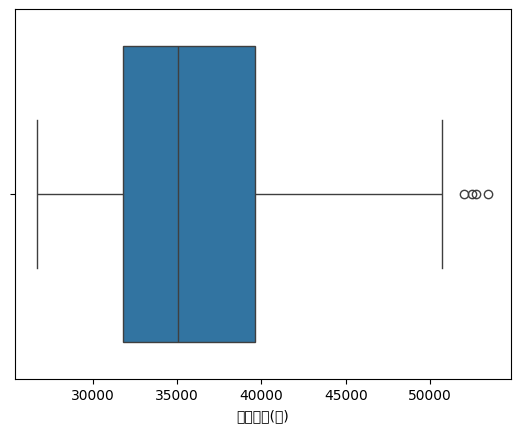

In [ ]:
sns.boxplot(x = "평균가격(원)", data = 품목별_train_data['배'])
plt.show()

이상치 제거는.. 일단 패스

## 5.깐마늘(국산)

In [ ]:
품목별_train_data['깐마늘(국산)']

,평년 평균가격(원),평균가격(원),공판장_총반입량(kg),공판장_총거래금액(원),공판장_평균가(원/kg),공판장_중간가(원/kg),공판장_최저가(원/kg),공판장_최고가(원/kg),공판장_경매 건수,공판장_전순 평균가격(원) PreVious SOON,...,도매_저가(20%) 평균가,도매_중간가(원/kg),도매_최저가(원/kg),도매_최고가(원/kg),도매_경매 건수,도매_전순 평균가격(원) PreVious SOON,도매_전달 평균가격(원) PreVious MMonth,도매_전년 평균가격(원) PreVious YeaR,도매_평년 평균가격(원) Common Year SOON,도매_연도
0,0.0,130666.666667,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,4345.360210,5940.000000,0.0,65000.000000,1143,88772.621712,88524.522893,99929.109521,79425.718243,2018
1,0.0,130600.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,3978.965942,5900.000000,0.0,35500.000000,1302,5611.944757,88675.577541,130183.818817,74864.409422,2018
2,0.0,130600.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,3801.950431,5900.000000,0.0,35500.000000,1315,5462.391757,88772.621712,97896.960468,70306.711496,2018
3,0.0,134614.500000,30.0,204000.0,6800.000000,6800.0,6800.0,6800.0,1.0,0.0,...,4419.528474,6000.000000,0.0,40350.866667,1349,5458.438088,5611.944757,106000.341889,77620.538880,2018
4,0.0,137100.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,4226.473596,6185.361111,0.0,39824.533333,790,5692.221683,5462.391757,97511.742911,77467.681378,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,0.0,167200.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,6006.737003,8250.000000,3000.0,15000.000000,108,6947.070590,7113.938521,5520.842973,35013.768821,2021
140,0.0,169100.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,5712.948518,8300.000000,2000.0,15000.000000,94,7547.747520,7301.848376,5320.888874,38447.435799,2021
141,0.0,169100.000000,120.0,870000.0,7250.000000,7000.0,7000.0,7300.0,3.0,0.0,...,3651.244678,8250.000000,2000.0,15000.000000,116,7143.421537,6947.070590,5314.422313,32846.493822,2021
142,0.0,169100.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,6113.966707,8500.000000,3000.0,15500.000000,103,6691.584598,7547.747520,5371.294066,32853.516530,2021


In [ ]:
# 각 column 별로 0인 셀들의 갯수를 계산합니다.
zeros_per_column = (품목별_train_data['깐마늘(국산)'] == 0).sum()
print(zeros_per_column)

평년 평균가격(원)                         144
평균가격(원)                              0
공판장_총반입량(kg)                        33
공판장_총거래금액(원)                        33
공판장_평균가(원/kg)                       33
공판장_중간가(원/kg)                       33
공판장_최저가(원/kg)                       33
공판장_최고가(원/kg)                       33
공판장_경매 건수                           33
공판장_전순 평균가격(원) PreVious SOON        46
공판장_전달 평균가격(원) PreVious MMonth      50
공판장_전년 평균가격(원) PreVious YeaR        64
공판장_평년 평균가격(원) Common Year SOON    141
공판장_연도                              33
도매_총반입량(kg)                          0
도매_총거래금액(원)                          0
도매_평균가(원/kg)                         0
도매_고가(20%) 평균가                       0
도매_중가(60%) 평균가                       0
도매_저가(20%) 평균가                       0
도매_중간가(원/kg)                         0
도매_최저가(원/kg)                        86
도매_최고가(원/kg)                         0
도매_경매 건수                             0
도매_전순 평균가격(원) PreVious SOON          0
도매_전달 평균가격(원) PreVious MM

'평년 평균 가격(원)' 이 중요한 컬럼이라고 생각이 들긴 하지만.. 값이 단 한개도 없음 -> 드랍

'공판장_평년 평균가격(원) Common Year SOON' -> 이것도 결측치가 많으니까 드랍

나머지는 다른 값으로 채워보고 싶은데 일단 패스

In [ ]:
품목별_train_data['깐마늘(국산)'].columns

Index(['평년 평균가격(원)', '평균가격(원)', '공판장_총반입량(kg)', '공판장_총거래금액(원)',
       '공판장_평균가(원/kg)', '공판장_중간가(원/kg)', '공판장_최저가(원/kg)', '공판장_최고가(원/kg)',
       '공판장_경매 건수', '공판장_전순 평균가격(원) PreVious SOON',
       '공판장_전달 평균가격(원) PreVious MMonth', '공판장_전년 평균가격(원) PreVious YeaR',
       '공판장_평년 평균가격(원) Common Year SOON', '공판장_연도', '도매_총반입량(kg)',
       '도매_총거래금액(원)', '도매_평균가(원/kg)', '도매_고가(20%) 평균가', '도매_중가(60%) 평균가 ',
       '도매_저가(20%) 평균가', '도매_중간가(원/kg)', '도매_최저가(원/kg)', '도매_최고가(원/kg)',
       '도매_경매 건수', '도매_전순 평균가격(원) PreVious SOON',
       '도매_전달 평균가격(원) PreVious MMonth', '도매_전년 평균가격(원) PreVious YeaR',
       '도매_평년 평균가격(원) Common Year SOON', '도매_연도'],
      dtype='object')

In [ ]:
품목별_test_data['깐마늘(국산)'].columns

Index(['평년 평균가격(원)', '평균가격(원)', '공판장_총반입량(kg)', '공판장_총거래금액(원)',
       '공판장_평균가(원/kg)', '공판장_중간가(원/kg)', '공판장_최저가(원/kg)', '공판장_최고가(원/kg)',
       '공판장_경매 건수', '공판장_전순 평균가격(원) PreVious SOON',
       '공판장_전달 평균가격(원) PreVious MMonth', '공판장_전년 평균가격(원) PreVious YeaR',
       '공판장_연도', '도매_총반입량(kg)', '도매_총거래금액(원)', '도매_평균가(원/kg)',
       '도매_고가(20%) 평균가', '도매_중가(60%) 평균가 ', '도매_저가(20%) 평균가', '도매_중간가(원/kg)',
       '도매_최고가(원/kg)', '도매_경매 건수', '도매_전순 평균가격(원) PreVious SOON',
       '도매_전달 평균가격(원) PreVious MMonth', '도매_전년 평균가격(원) PreVious YeaR',
       '도매_평년 평균가격(원) Common Year SOON', '도매_연도'],
      dtype='object')

In [ ]:
품목별_train_data['깐마늘(국산)'].drop(['평년 평균가격(원)', '공판장_평년 평균가격(원) Common Year SOON'], inplace=True, axis=1)
품목별_test_data['깐마늘(국산)'].drop(['평년 평균가격(원)'], inplace=True, axis=1)

## 6.무

In [ ]:
품목별_train_data['무']

,평년 평균가격(원),평균가격(원),공판장_총반입량(kg),공판장_총거래금액(원),공판장_평균가(원/kg),공판장_중간가(원/kg),공판장_최저가(원/kg),공판장_최고가(원/kg),공판장_경매 건수,공판장_전순 평균가격(원) PreVious SOON,...,도매_저가(20%) 평균가,도매_중간가(원/kg),도매_최저가(원/kg),도매_최고가(원/kg),도매_경매 건수,도매_전순 평균가격(원) PreVious SOON,도매_전달 평균가격(원) PreVious MMonth,도매_전년 평균가격(원) PreVious YeaR,도매_평년 평균가격(원) Common Year SOON,도매_연도
0,0.0,9283.571429,51700.0,13442400,260.007737,263.225186,224.901099,298.418367,8,322.803236,...,259.936736,370.360276,100.000000,800.000000,46.0,0.000000,0.000000,0.0,0.0,2018.0
1,0.0,9259.888889,42720.0,11066500,259.047285,235.638298,150.000000,338.476562,9,260.007737,...,163.244871,350.000000,25.000000,455.000000,53.0,356.497308,0.000000,0.0,0.0,2018.0
2,0.0,10576.111111,36910.0,11712900,317.336765,368.450949,161.997354,530.435967,8,259.047285,...,245.950035,377.424812,65.882353,645.000000,35.0,331.123205,0.000000,0.0,0.0,2018.0
3,0.0,18371.444444,46518.0,32240300,693.071499,651.529274,455.333333,886.111111,8,317.336765,...,230.516419,511.169811,85.800000,3800.000000,54.0,343.210618,356.497308,0.0,0.0,2018.0
4,0.0,19545.666667,25330.0,17240050,680.617844,710.167910,543.070652,1002.777778,5,693.071499,...,232.191316,446.226415,152.838346,855.075472,37.0,587.761288,331.123205,0.0,0.0,2018.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,0.0,12581.111111,10463.0,4939450,472.087355,474.094488,340.157039,1500.000000,7,372.562952,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
140,0.0,11107.375000,9067.0,3766900,415.451638,323.833544,263.518519,815.748031,7,472.087355,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
141,0.0,11457.666667,9779.0,4315720,441.325289,466.789137,319.429348,787.500000,9,415.451638,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
142,0.0,10597.750000,16900.0,5260000,311.242604,297.301920,115.000000,420.103627,6,441.325289,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0


In [ ]:
# 각 column 별로 0인 셀들의 갯수를 계산합니다.
zeros_per_column = (품목별_train_data['무'] == 0).sum()
print(zeros_per_column)

평년 평균가격(원)                         144
평균가격(원)                              0
공판장_총반입량(kg)                         0
공판장_총거래금액(원)                         0
공판장_평균가(원/kg)                        0
공판장_중간가(원/kg)                        0
공판장_최저가(원/kg)                        0
공판장_최고가(원/kg)                        0
공판장_경매 건수                            0
공판장_전순 평균가격(원) PreVious SOON         0
공판장_전달 평균가격(원) PreVious MMonth       0
공판장_전년 평균가격(원) PreVious YeaR         1
공판장_평년 평균가격(원) Common Year SOON    110
공판장_연도                               0
도매_총반입량(kg)                         18
도매_총거래금액(원)                         18
도매_평균가(원/kg)                        18
도매_고가(20%) 평균가                      20
도매_중가(60%) 평균가                      21
도매_저가(20%) 평균가                      18
도매_중간가(원/kg)                        18
도매_최저가(원/kg)                        23
도매_최고가(원/kg)                        18
도매_경매 건수                            18
도매_전순 평균가격(원) PreVious SOON         20
도매_전달 평균가격(원) PreVious MM

결측치 많은 3개의 열 드랍

In [ ]:
품목별_train_data['무'].columns

Index(['평년 평균가격(원)', '평균가격(원)', '공판장_총반입량(kg)', '공판장_총거래금액(원)',
       '공판장_평균가(원/kg)', '공판장_중간가(원/kg)', '공판장_최저가(원/kg)', '공판장_최고가(원/kg)',
       '공판장_경매 건수', '공판장_전순 평균가격(원) PreVious SOON',
       '공판장_전달 평균가격(원) PreVious MMonth', '공판장_전년 평균가격(원) PreVious YeaR',
       '공판장_평년 평균가격(원) Common Year SOON', '공판장_연도', '도매_총반입량(kg)',
       '도매_총거래금액(원)', '도매_평균가(원/kg)', '도매_고가(20%) 평균가', '도매_중가(60%) 평균가 ',
       '도매_저가(20%) 평균가', '도매_중간가(원/kg)', '도매_최저가(원/kg)', '도매_최고가(원/kg)',
       '도매_경매 건수', '도매_전순 평균가격(원) PreVious SOON',
       '도매_전달 평균가격(원) PreVious MMonth', '도매_전년 평균가격(원) PreVious YeaR',
       '도매_평년 평균가격(원) Common Year SOON', '도매_연도'],
      dtype='object')

In [ ]:
품목별_test_data['무'].columns

Index(['평균가격(원)', '공판장_총반입량(kg)', '공판장_총거래금액(원)', '공판장_평균가(원/kg)',
       '공판장_중간가(원/kg)', '공판장_최저가(원/kg)', '공판장_최고가(원/kg)', '공판장_경매 건수',
       '공판장_전순 평균가격(원) PreVious SOON', '공판장_전달 평균가격(원) PreVious MMonth',
       '공판장_전년 평균가격(원) PreVious YeaR', '공판장_연도', '도매_총반입량(kg)', '도매_총거래금액(원)',
       '도매_평균가(원/kg)', '도매_고가(20%) 평균가', '도매_중가(60%) 평균가 ', '도매_저가(20%) 평균가',
       '도매_중간가(원/kg)', '도매_최고가(원/kg)', '도매_경매 건수',
       '도매_전순 평균가격(원) PreVious SOON', '도매_전달 평균가격(원) PreVious MMonth',
       '도매_전년 평균가격(원) PreVious YeaR', '도매_평년 평균가격(원) Common Year SOON',
       '도매_연도'],
      dtype='object')

In [ ]:
품목별_train_data['무'].drop(['평년 평균가격(원)', '공판장_평년 평균가격(원) Common Year SOON', '도매_평년 평균가격(원) Common Year SOON'], inplace=True, axis=1)
품목별_test_data['무'].drop(['도매_평년 평균가격(원) Common Year SOON'], inplace=True, axis=1)

## 7.상추

In [ ]:
품목별_train_data['상추']

,평년 평균가격(원),평균가격(원),공판장_총반입량(kg),공판장_총거래금액(원),공판장_평균가(원/kg),공판장_중간가(원/kg),공판장_최저가(원/kg),공판장_최고가(원/kg),공판장_경매 건수,공판장_전순 평균가격(원) PreVious SOON,...,도매_저가(20%) 평균가,도매_중간가(원/kg),도매_최저가(원/kg),도매_최고가(원/kg),도매_경매 건수,도매_전순 평균가격(원) PreVious SOON,도매_전달 평균가격(원) PreVious MMonth,도매_전년 평균가격(원) PreVious YeaR,도매_평년 평균가격(원) Common Year SOON,도매_연도
0,1034.666667,940.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2461.358901,3750.000000,0.000000,10000.0,1446,14079.078027,5426.843900,6863.550198,18533.910588,2018
1,921.666667,981.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2474.124242,3750.000000,0.000000,12502.5,1594,3652.699743,9089.331473,6279.758912,12239.504008,2018
2,850.000000,983.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2138.467305,3551.348039,0.000000,10443.0,1594,3694.062635,14079.078027,8517.416324,13454.091416,2018
3,850.000000,1009.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2912.719254,4100.000000,250.000000,30000.0,1575,3461.811626,3652.699743,6187.804841,13994.713906,2018
4,844.666667,1022.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2012.743110,3500.000000,0.000000,13937.5,1027,4155.607145,3694.062635,6949.809183,9683.692252,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,843.000000,1208.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1414.877545,2350.000000,250.000000,14330.0,1661,3366.602748,6649.500058,1792.648402,3277.534074,2021
140,762.666667,1062.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1281.250110,2050.000000,250.000000,18000.0,1744,2438.716361,11156.592448,1451.143628,2897.733458,2021
141,717.000000,946.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1737.333991,2436.440678,625.000000,15504.0,227,2253.556034,3366.602748,2698.046078,3416.519073,2021
142,742.666667,931.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1383.804846,2175.000000,250.000000,15474.0,1680,2723.603863,2438.716361,3090.609243,3745.774789,2021


In [ ]:
# 각 column 별로 0인 셀들의 갯수를 계산합니다.
zeros_per_column = (품목별_train_data['상추'] == 0).sum()
print(zeros_per_column)

평년 평균가격(원)                           0
평균가격(원)                              0
공판장_총반입량(kg)                       138
공판장_총거래금액(원)                       138
공판장_평균가(원/kg)                      138
공판장_중간가(원/kg)                      138
공판장_최저가(원/kg)                      138
공판장_최고가(원/kg)                      138
공판장_경매 건수                          138
공판장_전순 평균가격(원) PreVious SOON       144
공판장_전달 평균가격(원) PreVious MMonth     144
공판장_전년 평균가격(원) PreVious YeaR       143
공판장_평년 평균가격(원) Common Year SOON    144
공판장_연도                             138
도매_총반입량(kg)                          0
도매_총거래금액(원)                          0
도매_평균가(원/kg)                         0
도매_고가(20%) 평균가                       0
도매_중가(60%) 평균가                       0
도매_저가(20%) 평균가                       0
도매_중간가(원/kg)                         0
도매_최저가(원/kg)                        81
도매_최고가(원/kg)                         0
도매_경매 건수                             0
도매_전순 평균가격(원) PreVious SOON          0
도매_전달 평균가격(원) PreVious MM

In [ ]:
품목별_train_data['상추'].columns

Index(['평년 평균가격(원)', '평균가격(원)', '공판장_총반입량(kg)', '공판장_총거래금액(원)',
       '공판장_평균가(원/kg)', '공판장_중간가(원/kg)', '공판장_최저가(원/kg)', '공판장_최고가(원/kg)',
       '공판장_경매 건수', '공판장_전순 평균가격(원) PreVious SOON',
       '공판장_전달 평균가격(원) PreVious MMonth', '공판장_전년 평균가격(원) PreVious YeaR',
       '공판장_평년 평균가격(원) Common Year SOON', '공판장_연도', '도매_총반입량(kg)',
       '도매_총거래금액(원)', '도매_평균가(원/kg)', '도매_고가(20%) 평균가', '도매_중가(60%) 평균가 ',
       '도매_저가(20%) 평균가', '도매_중간가(원/kg)', '도매_최저가(원/kg)', '도매_최고가(원/kg)',
       '도매_경매 건수', '도매_전순 평균가격(원) PreVious SOON',
       '도매_전달 평균가격(원) PreVious MMonth', '도매_전년 평균가격(원) PreVious YeaR',
       '도매_평년 평균가격(원) Common Year SOON', '도매_연도'],
      dtype='object')

In [ ]:
품목별_test_data['상추'].columns

Index(['평균가격(원)', '공판장_총반입량(kg)', '공판장_총거래금액(원)', '공판장_평균가(원/kg)',
       '공판장_중간가(원/kg)', '공판장_최저가(원/kg)', '공판장_최고가(원/kg)', '공판장_경매 건수',
       '공판장_전순 평균가격(원) PreVious SOON', '공판장_전달 평균가격(원) PreVious MMonth',
       '공판장_전년 평균가격(원) PreVious YeaR', '공판장_연도', '도매_총반입량(kg)', '도매_총거래금액(원)',
       '도매_평균가(원/kg)', '도매_고가(20%) 평균가', '도매_중가(60%) 평균가 ', '도매_저가(20%) 평균가',
       '도매_중간가(원/kg)', '도매_최고가(원/kg)', '도매_경매 건수',
       '도매_전순 평균가격(원) PreVious SOON', '도매_전달 평균가격(원) PreVious MMonth',
       '도매_전년 평균가격(원) PreVious YeaR', '도매_연도'],
      dtype='object')

In [ ]:
품목별_train_data['상추'].drop(['공판장_총반입량(kg)', '공판장_총거래금액(원)',
       '공판장_평균가(원/kg)', '공판장_중간가(원/kg)', '공판장_최저가(원/kg)', '공판장_최고가(원/kg)',
       '공판장_경매 건수', '공판장_전순 평균가격(원) PreVious SOON',
       '공판장_전달 평균가격(원) PreVious MMonth', '공판장_전년 평균가격(원) PreVious YeaR',
       '공판장_평년 평균가격(원) Common Year SOON', '공판장_연도'], inplace=True, axis=1)
품목별_test_data['상추'].drop(['공판장_총반입량(kg)', '공판장_총거래금액(원)',
       '공판장_평균가(원/kg)', '공판장_중간가(원/kg)', '공판장_최저가(원/kg)', '공판장_최고가(원/kg)',
       '공판장_경매 건수', '공판장_전순 평균가격(원) PreVious SOON',
       '공판장_전달 평균가격(원) PreVious MMonth', '공판장_전년 평균가격(원) PreVious YeaR', '공판장_연도'], inplace=True, axis=1)

## 8.배추

In [ ]:
품목별_train_data['배추']

,평년 평균가격(원),평균가격(원),공판장_총반입량(kg),공판장_총거래금액(원),공판장_평균가(원/kg),공판장_중간가(원/kg),공판장_최저가(원/kg),공판장_최고가(원/kg),공판장_경매 건수,공판장_전순 평균가격(원) PreVious SOON,...,도매_저가(20%) 평균가,도매_중간가(원/kg),도매_최저가(원/kg),도매_최고가(원/kg),도매_경매 건수,도매_전순 평균가격(원) PreVious SOON,도매_전달 평균가격(원) PreVious MMonth,도매_전년 평균가격(원) PreVious YeaR,도매_평년 평균가격(원) Common Year SOON,도매_연도
0,6071.726190,5419.857143,1147.0,436700.0,380.732345,379.342723,269.230769,461.538462,6.0,421.717791,...,331.651915,354.963938,66.666667,950.000000,74.0,0.000000,0.000000,0.000000,0.0,2018.0
1,5938.143519,5319.333333,569.0,359400.0,631.634446,615.384615,500.000000,815.384615,5.0,380.732345,...,321.277767,380.000000,28.571429,928.571429,107.0,442.359033,0.000000,0.000000,0.0,2018.0
2,6245.351852,6734.777778,1508.0,1014150.0,672.513263,626.562500,529.910714,1023.461538,7.0,631.634446,...,311.656727,394.859307,55.555556,2625.000000,84.0,478.782019,0.000000,0.000000,0.0,2018.0
3,6413.720238,8942.222222,813.0,643590.0,791.623616,813.682310,584.615385,1100.000000,5.0,672.513263,...,435.618714,669.895833,71.428571,2000.000000,128.0,451.207389,442.359033,0.000000,0.0,2018.0
4,7099.146825,7247.166667,2432.0,1447500.0,595.189145,697.394137,547.584381,877.500000,4.0,791.623616,...,312.232951,500.000000,85.714286,1192.258065,75.0,717.706917,478.782019,0.000000,0.0,2018.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,6978.472222,10626.888889,80.0,68000.0,850.000000,800.000000,250.000000,2100.000000,3.0,539.534884,...,750.000000,840.154867,750.000000,900.000000,3.0,374.393531,617.074484,384.806977,0.0,2021.0
140,6501.689815,9273.250000,776.0,778425.0,1003.125000,939.062500,300.000000,1040.317460,4.0,850.000000,...,660.633484,687.500000,358.974359,937.500000,7.0,790.299906,500.560224,305.183522,0.0,2021.0
141,5969.171296,8281.777778,120.0,105000.0,875.000000,875.000000,875.000000,875.000000,1.0,1003.125000,...,557.575758,557.575758,557.575758,557.575758,1.0,769.382022,374.393531,190.942864,0.0,2021.0
142,5978.449074,7667.375000,256.0,197500.0,771.484375,656.250000,350.000000,937.500000,4.0,875.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0


In [ ]:
# 각 column 별로 0인 셀들의 갯수를 계산합니다.
zeros_per_column = (품목별_train_data['배추'] == 0).sum()
print(zeros_per_column)

평년 평균가격(원)                           0
평균가격(원)                              0
공판장_총반입량(kg)                         6
공판장_총거래금액(원)                         6
공판장_평균가(원/kg)                        6
공판장_중간가(원/kg)                        6
공판장_최저가(원/kg)                        6
공판장_최고가(원/kg)                        6
공판장_경매 건수                            6
공판장_전순 평균가격(원) PreVious SOON        10
공판장_전달 평균가격(원) PreVious MMonth      11
공판장_전년 평균가격(원) PreVious YeaR        14
공판장_평년 평균가격(원) Common Year SOON    121
공판장_연도                               6
도매_총반입량(kg)                          3
도매_총거래금액(원)                          3
도매_평균가(원/kg)                         3
도매_고가(20%) 평균가                      10
도매_중가(60%) 평균가                       7
도매_저가(20%) 평균가                       3
도매_중간가(원/kg)                         3
도매_최저가(원/kg)                        10
도매_최고가(원/kg)                         3
도매_경매 건수                             3
도매_전순 평균가격(원) PreVious SOON          5
도매_전달 평균가격(원) PreVious MM

In [ ]:
품목별_test_data['배추'].columns

Index(['평균가격(원)', '도매_총반입량(kg)', '도매_총거래금액(원)', '도매_평균가(원/kg)',
       '도매_고가(20%) 평균가', '도매_중가(60%) 평균가 ', '도매_저가(20%) 평균가', '도매_중간가(원/kg)',
       '도매_최고가(원/kg)', '도매_경매 건수', '도매_전순 평균가격(원) PreVious SOON',
       '도매_전달 평균가격(원) PreVious MMonth', '도매_전년 평균가격(원) PreVious YeaR',
       '도매_연도'],
      dtype='object')

In [ ]:
품목별_train_data['배추'].drop(['공판장_평년 평균가격(원) Common Year SOON', '도매_평년 평균가격(원) Common Year SOON'], inplace=True, axis=1)

## 9.양파

In [ ]:
품목별_train_data['양파']

,평년 평균가격(원),평균가격(원),공판장_총반입량(kg),공판장_총거래금액(원),공판장_평균가(원/kg),공판장_중간가(원/kg),공판장_최저가(원/kg),공판장_최고가(원/kg),공판장_경매 건수,공판장_전순 평균가격(원) PreVious SOON,...,도매_저가(20%) 평균가,도매_중간가(원/kg),도매_최저가(원/kg),도매_최고가(원/kg),도매_경매 건수,도매_전순 평균가격(원) PreVious SOON,도매_전달 평균가격(원) PreVious MMonth,도매_전년 평균가격(원) PreVious YeaR,도매_평년 평균가격(원) Common Year SOON,도매_연도
0,1149.125000,1144.428571,5437.0,4553700,837.539084,835.264706,581.481481,951.167728,8,1029.538747,...,778.876329,1000.000000,200.0,1720.000000,539,818983.746266,278734.522678,6.447362e+05,278116.769159,2018
1,1125.013889,1041.222222,3546.0,2948700,831.556684,923.765002,526.315789,1105.588235,8,837.539084,...,745.547948,950.000000,0.0,1733.333333,551,968.108693,351578.927444,8.906190e+05,357531.525806,2018
2,1180.733333,1036.444444,7125.0,6527575,916.150877,745.000000,594.324324,1001.176471,7,831.556684,...,686.820275,946.666667,0.0,1733.333333,515,930.706357,818983.746266,1.383191e+06,452651.066199,2018
3,1192.203704,1045.777778,11975.0,9507800,793.970772,840.060214,565.000000,1060.000000,8,916.150877,...,741.376875,966.666667,200.0,19045.000000,660,902.475238,968.108693,4.900736e+05,218740.692921,2018
4,1133.856481,1098.166667,1360.0,1106050,813.272059,500.000000,493.333333,997.732558,3,793.970772,...,719.925488,956.172070,0.0,9520.000000,307,933.688026,930.706357,9.710578e+05,355207.883533,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,975.958333,908.666667,12401.0,9674237,780.117491,783.155080,645.558081,910.000000,7,791.138317,...,637.146581,870.416667,0.0,2000.000000,893,842.795259,841.114352,1.142582e+03,167415.958587,2021
140,952.703704,855.000000,27354.0,22039314,805.707173,815.340577,742.846229,889.166667,8,780.117491,...,599.363151,809.917355,0.0,2400.000000,827,818.267404,852.913168,1.153936e+03,183611.329582,2021
141,986.458333,816.333333,16871.0,12892816,764.199870,776.170213,685.679012,925.000000,9,805.707173,...,603.251081,768.473567,0.0,2090.000000,1012,788.307922,842.795259,1.135135e+03,84043.639773,2021
142,960.250000,734.875000,11615.0,8345822,718.538269,710.464088,570.652174,900.000000,6,764.199870,...,529.429295,706.868687,0.0,9000.000000,810,759.466971,818.267404,1.182391e+03,117815.202620,2021


In [ ]:
# 각 column 별로 0인 셀들의 갯수를 계산합니다.
zeros_per_column = (품목별_train_data['양파'] == 0).sum()
print(zeros_per_column)

평년 평균가격(원)                           0
평균가격(원)                              0
공판장_총반입량(kg)                         0
공판장_총거래금액(원)                         0
공판장_평균가(원/kg)                        0
공판장_중간가(원/kg)                        0
공판장_최저가(원/kg)                        0
공판장_최고가(원/kg)                        0
공판장_경매 건수                            0
공판장_전순 평균가격(원) PreVious SOON         0
공판장_전달 평균가격(원) PreVious MMonth       0
공판장_전년 평균가격(원) PreVious YeaR         0
공판장_평년 평균가격(원) Common Year SOON    108
공판장_연도                               0
도매_총반입량(kg)                          0
도매_총거래금액(원)                          0
도매_평균가(원/kg)                         0
도매_고가(20%) 평균가                       0
도매_중가(60%) 평균가                       0
도매_저가(20%) 평균가                       0
도매_중간가(원/kg)                         0
도매_최저가(원/kg)                        93
도매_최고가(원/kg)                         0
도매_경매 건수                             0
도매_전순 평균가격(원) PreVious SOON          0
도매_전달 평균가격(원) PreVious MM

In [ ]:
품목별_test_data['양파'].columns

Index(['평균가격(원)', '도매_총반입량(kg)', '도매_총거래금액(원)', '도매_평균가(원/kg)',
       '도매_고가(20%) 평균가', '도매_중가(60%) 평균가 ', '도매_저가(20%) 평균가', '도매_중간가(원/kg)',
       '도매_최고가(원/kg)', '도매_경매 건수', '도매_전순 평균가격(원) PreVious SOON',
       '도매_전달 평균가격(원) PreVious MMonth', '도매_전년 평균가격(원) PreVious YeaR',
       '도매_연도'],
      dtype='object')

In [ ]:
품목별_train_data['양파'].drop(['공판장_평년 평균가격(원) Common Year SOON', '도매_최저가(원/kg)'], inplace=True, axis=1)

## 10.대파

In [ ]:
품목별_train_data['대파']

,평균가격(원),도매_총반입량(kg),도매_총거래금액(원),도매_평균가(원/kg),도매_고가(20%) 평균가,도매_중가(60%) 평균가,도매_저가(20%) 평균가,도매_중간가(원/kg),도매_최고가(원/kg),도매_경매 건수,도매_전순 평균가격(원) PreVious SOON,도매_전달 평균가격(원) PreVious MMonth,도매_전년 평균가격(원) PreVious YeaR,도매_연도
0,1685.285714,5929872.00,8381397718,1413.419669,1801.585846,1447.998838,928.820940,1400.000000,12000.000000,2378,2683.460539,9595.902402,3964.009533,2018
1,1624.888889,6122203.30,8585576852,1402.367160,1784.403977,1410.600924,1010.670280,1460.000000,12190.000000,2641,1413.419669,2746.309547,3559.376068,2018
2,1834.333333,6311902.20,9289966136,1471.817186,2148.366179,1427.798321,953.370036,1500.000000,15000.000000,2705,1402.448110,2683.460539,3659.592928,2018
3,2530.111111,7027956.40,15200877978,2162.915806,2851.025755,2184.037459,1439.821871,2200.000000,16000.000000,3169,1471.817186,1413.419669,3690.061030,2018
4,1537.833333,5265724.90,7940847214,1508.025460,2434.203499,1465.190426,781.001593,1665.615764,7738.000000,2002,2162.890905,1402.448110,3336.429133,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1754.222222,5702401.10,8475153353,1486.242936,2017.058506,1478.034906,980.897530,1337.083333,26550.000000,4226,1361.472556,1271.163760,2399.391298,2021
140,1460.250000,5312147.60,6147217242,1157.200007,1596.804131,1144.510914,756.762411,1050.000000,8000.000000,3786,1486.223470,1330.590568,1981.463660,2021
141,1619.000000,5584110.90,7374569282,1320.634460,1823.664725,1301.935283,874.836602,1216.393443,3866.166667,3753,1157.210533,1361.472556,1608.308102,2021
142,1217.125000,5167050.40,5328881661,1031.319853,1349.095547,1040.295195,693.569200,987.894737,6509.500000,3029,1320.617115,1486.223470,1694.464881,2021


In [ ]:
# 각 column 별로 0인 셀들의 갯수를 계산합니다.
zeros_per_column = (품목별_train_data['대파'] == 0).sum()
print(zeros_per_column)

평균가격(원)                          0
도매_총반입량(kg)                      0
도매_총거래금액(원)                      0
도매_평균가(원/kg)                     0
도매_고가(20%) 평균가                   0
도매_중가(60%) 평균가                   0
도매_저가(20%) 평균가                   0
도매_중간가(원/kg)                     0
도매_최고가(원/kg)                     0
도매_경매 건수                         0
도매_전순 평균가격(원) PreVious SOON      0
도매_전달 평균가격(원) PreVious MMonth    0
도매_전년 평균가격(원) PreVious YeaR      0
도매_연도                            0
dtype: int64


In [ ]:
품목별_test_data['대파'].columns

Index(['평균가격(원)', '도매_총반입량(kg)', '도매_총거래금액(원)', '도매_평균가(원/kg)',
       '도매_고가(20%) 평균가', '도매_중가(60%) 평균가 ', '도매_저가(20%) 평균가', '도매_중간가(원/kg)',
       '도매_최고가(원/kg)', '도매_경매 건수', '도매_전순 평균가격(원) PreVious SOON',
       '도매_전달 평균가격(원) PreVious MMonth', '도매_전년 평균가격(원) PreVious YeaR',
       '도매_연도'],
      dtype='object')

# 학습 및 추론

In [ ]:
config = {
    "learning_rate": 2e-5,
    "epoch": 30,
    "batch_size": 64,
    "hidden_size": 64,
    "num_layers": 2,
    "output_size": 3
}

CFG = SimpleNamespace(**config)

In [ ]:

class PricePredictionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(PricePredictionLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            total_loss += loss.item()
    return total_loss / len(test_loader)

In [ ]:
sub_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   시점       75 non-null     object 
 1   감자       75 non-null     float64
 2   건고추      75 non-null     float64
 3   깐마늘(국산)  75 non-null     float64
 4   대파       75 non-null     float64
 5   무        75 non-null     float64
 6   배추       75 non-null     float64
 7   사과       75 non-null     float64
 8   상추       75 non-null     float64
 9   양파       75 non-null     float64
 10  배        75 non-null     float64
dtypes: float64(10), object(1)
memory usage: 6.6+ KB


## 감자 학습

In [ ]:
train_df.columns

Index(['시점', '품목명', '품종명', '거래단위', '등급', '평년 평균가격(원)', '평균가격(원)'], dtype='object')

In [ ]:
품목별_test_data['감자'].columns

Index(['평균가격(원)', '도매_총반입량(kg)', '도매_총거래금액(원)', '도매_평균가(원/kg)',
       '도매_고가(20%) 평균가', '도매_중가(60%) 평균가 ', '도매_저가(20%) 평균가', '도매_중간가(원/kg)',
       '도매_최고가(원/kg)', '도매_경매 건수', '도매_전순 평균가격(원) PreVious SOON',
       '도매_전달 평균가격(원) PreVious MMonth', '도매_전년 평균가격(원) PreVious YeaR',
       '도매_연도'],
      dtype='object')

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# 1. 데이터 준비
# 학습 데이터 로드
train_df = 품목별_train_data['감자']

# 필요한 피처만 선택 (시점 컬럼은 제거)
features = ['평년 평균가격(원)', '평균가격(원)', '공판장_총반입량(kg)', '공판장_총거래금액(원)',
       '공판장_평균가(원/kg)', '공판장_중간가(원/kg)', '공판장_최저가(원/kg)', '공판장_최고가(원/kg)',
       '공판장_경매 건수', '공판장_전순 평균가격(원) PreVious SOON',
       '공판장_전달 평균가격(원) PreVious MMonth', '공판장_전년 평균가격(원) PreVious YeaR',
       '공판장_연도', '도매_총반입량(kg)', '도매_총거래금액(원)', '도매_평균가(원/kg)',
       '도매_고가(20%) 평균가', '도매_중가(60%) 평균가 ', '도매_저가(20%) 평균가', '도매_중간가(원/kg)',
       '도매_최고가(원/kg)', '도매_경매 건수', '도매_전순 평균가격(원) PreVious SOON',
       '도매_전달 평균가격(원) PreVious MMonth', '도매_전년 평균가격(원) PreVious YeaR',
       '도매_평년 평균가격(원) Common Year SOON', '도매_연도']

# 감자 가격이 타겟
target = '평균가격(원)'

# 2. 데이터 전처리
# 피처와 타겟 분리
X_train = train_df[features].values
y_train = train_df[target].values

# 스케일링 (MinMaxScaler 사용)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))

# LSTM 입력 형태 맞추기 (samples, timesteps, features)
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))

# 3. 모델 학습
# LSTM 모델 정의
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 모델 학습
history = model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, validation_split=0.2, verbose=2)

# 4. 테스트 데이터 준비 및 예측
# 테스트 데이터를 준비합니다. 실제로는 이전 시점 데이터 또는 예측된 데이터를 기반으로 해야 합니다.
# 여기서는 예시로 임의의 데이터로 X_test를 준비합니다. 실제로는 제공된 데이터에 맞게 사용하세요.

# 예를 들어, 마지막 학습 데이터의 마지막 값으로부터 시작한다고 가정
X_test = X_train_scaled[-75:]

# 예측 수행 (75개의 시점에 대해 예측)
predicted_potato_prices_scaled = []
X_test_updated = X_test.copy()  # Create a copy of X_test to store updates

# 순차적으로 예측을 이어가는 방식
for i in range(75):
    predicted_price = model.predict(X_test_updated[-1].reshape(1, 1, X_test.shape[2]))
    predicted_potato_prices_scaled.append(predicted_price)
    # 새로 예측된 값을 X_test_updated에 추가 (다음 예측을 위해)
    # predicted_price의 shape을 (1, 1, 1)로 변경하여 X_test_updated에 추가
    # X_test_updated의 마지막 차원의 크기는 28이므로,
    # predicted_price를 28개의 값으로 복제하여 shape을 (1, 1, 28)로 만들어야 함
    predicted_price_reshaped = np.repeat(predicted_price, X_test.shape[2]).reshape(1, 1, X_test.shape[2])
    X_test_updated = np.concatenate([X_test_updated, predicted_price_reshaped], axis=0)

# Convert the list of predictions to a NumPy array and reshape it to (75, 1)
predicted_potato_prices_scaled = np.array(predicted_potato_prices_scaled).reshape(-1, 1)

# 스케일을 역변환하여 실제 값으로 변환
predicted_potato_prices = scaler_y.inverse_transform(predicted_potato_prices_scaled).flatten()

# 5. submission 파일에 예측값 저장

# 예측된 감자 가격을 75개의 셀에 채움
sub_df['감자'] = predicted_potato_prices[:75]

# 최종 제출 파일로 저장
sub_df.to_csv('final_submission.csv', index=False)

print("Submission 파일이 저장되었습니다.")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
4/4 - 3s - 660ms/step - loss: 0.0655 - val_loss: 0.0165
Epoch 2/50
4/4 - 0s - 90ms/step - loss: 0.0451 - val_loss: 0.0095
Epoch 3/50
4/4 - 0s - 18ms/step - loss: 0.0312 - val_loss: 0.0064
Epoch 4/50
4/4 - 0s - 14ms/step - loss: 0.0218 - val_loss: 0.0062
Epoch 5/50
4/4 - 0s - 14ms/step - loss: 0.0169 - val_loss: 0.0078
Epoch 6/50
4/4 - 0s - 14ms/step - loss: 0.0145 - val_loss: 0.0095
Epoch 7/50
4/4 - 0s - 15ms/step - loss: 0.0133 - val_loss: 0.0096
Epoch 8/50
4/4 - 0s - 17ms/step - loss: 0.0120 - val_loss: 0.0083
Epoch 9/50
4/4 - 0s - 33ms/step - loss: 0.0099 - val_loss: 0.0065
Epoch 10/50
4/4 - 0s - 15ms/step - loss: 0.0079 - val_loss: 0.0049
Epoch 11/50
4/4 - 0s - 16ms/step - loss: 0.0065 - val_loss: 0.0038
Epoch 12/50
4/4 - 0s - 17ms/step - loss: 0.0052 - val_loss: 0.0032
Epoch 13/50
4/4 - 0s - 31ms/step - loss: 0.0043 - val_loss: 0.0028
Epoch 14/50
4/4 - 0s - 14ms/step - loss: 0.0036 - val_loss: 0.0025
Epoch 15/50
4/4 - 0s - 14ms/step - loss: 0.0031 - val_loss: 0.0022
Epo

In [ ]:
sub_df

,시점,감자,건고추,깐마늘(국산),대파,무,배추,사과,상추,양파,배
0,TEST_00+1순,43858.152344,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,TEST_00+2순,43717.070312,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,TEST_00+3순,43577.539062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,TEST_01+1순,43439.750000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,TEST_01+2순,43303.886719,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
70,TEST_23+2순,39706.222656,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71,TEST_23+3순,39698.828125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
72,TEST_24+1순,39691.824219,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73,TEST_24+2순,39685.207031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


---
깐마늘

In [ ]:
품목별_train_data['깐마늘(국산)'].columns

Index(['평균가격(원)', '공판장_총반입량(kg)', '공판장_총거래금액(원)', '공판장_평균가(원/kg)',
       '공판장_중간가(원/kg)', '공판장_최저가(원/kg)', '공판장_최고가(원/kg)', '공판장_경매 건수',
       '공판장_전순 평균가격(원) PreVious SOON', '공판장_전달 평균가격(원) PreVious MMonth',
       '공판장_전년 평균가격(원) PreVious YeaR', '공판장_연도', '도매_총반입량(kg)', '도매_총거래금액(원)',
       '도매_평균가(원/kg)', '도매_고가(20%) 평균가', '도매_중가(60%) 평균가 ', '도매_저가(20%) 평균가',
       '도매_중간가(원/kg)', '도매_최저가(원/kg)', '도매_최고가(원/kg)', '도매_경매 건수',
       '도매_전순 평균가격(원) PreVious SOON', '도매_전달 평균가격(원) PreVious MMonth',
       '도매_전년 평균가격(원) PreVious YeaR', '도매_평년 평균가격(원) Common Year SOON',
       '도매_연도'],
      dtype='object')

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# 1. 데이터 준비
# 학습 데이터 로드
train_df = 품목별_train_data['깐마늘(국산)']

# 필요한 피처만 선택 (시점 컬럼은 제거)
features = ['평균가격(원)', '공판장_총반입량(kg)', '공판장_총거래금액(원)', '공판장_평균가(원/kg)',
       '공판장_중간가(원/kg)', '공판장_최저가(원/kg)', '공판장_최고가(원/kg)', '공판장_경매 건수',
       '공판장_전순 평균가격(원) PreVious SOON', '공판장_전달 평균가격(원) PreVious MMonth',
       '공판장_전년 평균가격(원) PreVious YeaR', '공판장_연도', '도매_총반입량(kg)', '도매_총거래금액(원)',
       '도매_평균가(원/kg)', '도매_고가(20%) 평균가', '도매_중가(60%) 평균가 ', '도매_저가(20%) 평균가',
       '도매_중간가(원/kg)', '도매_최저가(원/kg)', '도매_최고가(원/kg)', '도매_경매 건수',
       '도매_전순 평균가격(원) PreVious SOON', '도매_전달 평균가격(원) PreVious MMonth',
       '도매_전년 평균가격(원) PreVious YeaR', '도매_평년 평균가격(원) Common Year SOON',
       '도매_연도']

# 감자 가격이 타겟
target = '평균가격(원)'

# 2. 데이터 전처리
# 피처와 타겟 분리
X_train = train_df[features].values
y_train = train_df[target].values

# 스케일링 (MinMaxScaler 사용)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))

# LSTM 입력 형태 맞추기 (samples, timesteps, features)
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))

# 3. 모델 학습
# LSTM 모델 정의
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 모델 학습
history = model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, validation_split=0.2, verbose=2)

# 4. 테스트 데이터 준비 및 예측
# 테스트 데이터를 준비합니다. 실제로는 이전 시점 데이터 또는 예측된 데이터를 기반으로 해야 합니다.
# 여기서는 예시로 임의의 데이터로 X_test를 준비합니다. 실제로는 제공된 데이터에 맞게 사용하세요.

# 예를 들어, 마지막 학습 데이터의 마지막 값으로부터 시작한다고 가정
X_test = X_train_scaled[-75:]

# 예측 수행 (75개의 시점에 대해 예측)
predicted_potato_prices_scaled = []
X_test_updated = X_test.copy()  # Create a copy of X_test to store updates

# 순차적으로 예측을 이어가는 방식
for i in range(75):
    predicted_price = model.predict(X_test_updated[-1].reshape(1, 1, X_test.shape[2]))
    predicted_potato_prices_scaled.append(predicted_price)
    # 새로 예측된 값을 X_test_updated에 추가 (다음 예측을 위해)
    # predicted_price의 shape을 (1, 1, 1)로 변경하여 X_test_updated에 추가
    # X_test_updated의 마지막 차원의 크기는 28이므로,
    # predicted_price를 28개의 값으로 복제하여 shape을 (1, 1, 28)로 만들어야 함
    predicted_price_reshaped = np.repeat(predicted_price, X_test.shape[2]).reshape(1, 1, X_test.shape[2])
    X_test_updated = np.concatenate([X_test_updated, predicted_price_reshaped], axis=0)

# Convert the list of predictions to a NumPy array and reshape it to (75, 1)
predicted_potato_prices_scaled = np.array(predicted_potato_prices_scaled).reshape(-1, 1)

# 스케일을 역변환하여 실제 값으로 변환
predicted_potato_prices = scaler_y.inverse_transform(predicted_potato_prices_scaled).flatten()

# 5. submission 파일에 예측값 저장

# 예측된 감자 가격을 75개의 셀에 채움
sub_df['깐마늘(국산)'] = predicted_potato_prices[:75]

# 최종 제출 파일로 저장
sub_df.to_csv('final_submission.csv', index=False)

print("Submission 파일이 저장되었습니다.")


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 - 2s - 535ms/step - loss: 0.2395 - val_loss: 0.6503
Epoch 2/50
4/4 - 0s - 15ms/step - loss: 0.2010 - val_loss: 0.5766
Epoch 3/50
4/4 - 0s - 15ms/step - loss: 0.1674 - val_loss: 0.5054
Epoch 4/50
4/4 - 0s - 13ms/step - loss: 0.1382 - val_loss: 0.4362
Epoch 5/50
4/4 - 0s - 15ms/step - loss: 0.1130 - val_loss: 0.3695
Epoch 6/50
4/4 - 0s - 14ms/step - loss: 0.0899 - val_loss: 0.3074
Epoch 7/50
4/4 - 0s - 35ms/step - loss: 0.0702 - val_loss: 0.2513
Epoch 8/50
4/4 - 0s - 14ms/step - loss: 0.0567 - val_loss: 0.2013
Epoch 9/50
4/4 - 0s - 14ms/step - loss: 0.0467 - val_loss: 0.1603
Epoch 10/50
4/4 - 0s - 15ms/step - loss: 0.0410 - val_loss: 0.1294
Epoch 11/50
4/4 - 0s - 16ms/step - loss: 0.0378 - val_loss: 0.1079
Epoch 12/50
4/4 - 0s - 15ms/step - loss: 0.0355 - val_loss: 0.0955
Epoch 13/50
4/4 - 0s - 15ms/step - loss: 0.0330 - val_loss: 0.0876
Epoch 14/50
4/4 - 0s - 15ms/step - loss: 0.0298 - val_loss: 0.0840
Epoch 15/50
4/4 - 0s - 17ms/step - loss: 0.0268 - val_loss: 0.0816
Epoch 16/50
4/

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:575: RuntimeWarning: overflow encountered in divide
  X /= self.scale_


In [ ]:
sub_df

,시점,감자,건고추,깐마늘(국산),대파,무,배추,사과,상추,양파,배
0,TEST_00+1순,43858.152344,0.0,1.602252e+05,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,TEST_00+2순,43717.070312,0.0,2.154039e+05,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,TEST_00+3순,43577.539062,0.0,3.595618e+05,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,TEST_01+1순,43439.750000,0.0,7.994744e+05,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,TEST_01+2순,43303.886719,0.0,2.126406e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
70,TEST_23+2순,39706.222656,0.0,7.582713e+36,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71,TEST_23+3순,39698.828125,0.0,2.201954e+37,0.0,0.0,0.0,0.0,0.0,0.0,0.0
72,TEST_24+1순,39691.824219,0.0,6.394284e+37,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73,TEST_24+2순,39685.207031,0.0,1.856844e+38,0.0,0.0,0.0,0.0,0.0,0.0,0.0


---
건고추

In [ ]:
품목별_train_data['건고추'].columns

Index(['평년 평균가격(원)', '평균가격(원)'], dtype='object')

In [ ]:
# 1. 데이터 준비
# 학습 데이터 로드
train_df = 품목별_train_data['건고추']

# 필요한 피처만 선택 (시점 컬럼은 제거)
features = ['평년 평균가격(원)', '평균가격(원)']

# 감자 가격이 타겟
target = '평균가격(원)'

# 2. 데이터 전처리
# 피처와 타겟 분리
X_train = train_df[features].values
y_train = train_df[target].values

# 스케일링 (MinMaxScaler 사용)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))

# LSTM 입력 형태 맞추기 (samples, timesteps, features)
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))

# 3. 모델 학습
# LSTM 모델 정의
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 모델 학습
history = model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, validation_split=0.2, verbose=2)

# 4. 테스트 데이터 준비 및 예측
# 테스트 데이터를 준비합니다. 실제로는 이전 시점 데이터 또는 예측된 데이터를 기반으로 해야 합니다.
# 여기서는 예시로 임의의 데이터로 X_test를 준비합니다. 실제로는 제공된 데이터에 맞게 사용하세요.

# 예를 들어, 마지막 학습 데이터의 마지막 값으로부터 시작한다고 가정
X_test = X_train_scaled[-75:]

# 예측 수행 (75개의 시점에 대해 예측)
predicted_potato_prices_scaled = []
X_test_updated = X_test.copy()  # Create a copy of X_test to store updates

# 순차적으로 예측을 이어가는 방식
for i in range(75):
    predicted_price = model.predict(X_test_updated[-1].reshape(1, 1, X_test.shape[2]))
    predicted_potato_prices_scaled.append(predicted_price)
    # 새로 예측된 값을 X_test_updated에 추가 (다음 예측을 위해)
    # predicted_price의 shape을 (1, 1, 1)로 변경하여 X_test_updated에 추가
    # X_test_updated의 마지막 차원의 크기는 28이므로,
    # predicted_price를 28개의 값으로 복제하여 shape을 (1, 1, 28)로 만들어야 함
    predicted_price_reshaped = np.repeat(predicted_price, X_test.shape[2]).reshape(1, 1, X_test.shape[2])
    X_test_updated = np.concatenate([X_test_updated, predicted_price_reshaped], axis=0)

# Convert the list of predictions to a NumPy array and reshape it to (75, 1)
predicted_potato_prices_scaled = np.array(predicted_potato_prices_scaled).reshape(-1, 1)

# 스케일을 역변환하여 실제 값으로 변환
predicted_potato_prices = scaler_y.inverse_transform(predicted_potato_prices_scaled).flatten()

# 5. submission 파일에 예측값 저장

# 예측된 감자 가격을 75개의 셀에 채움
sub_df['건고추'] = predicted_potato_prices[:75]

# 최종 제출 파일로 저장
sub_df.to_csv('final_submission.csv', index=False)

print("Submission 파일이 저장되었습니다.")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
4/4 - 3s - 667ms/step - loss: 0.1974 - val_loss: 0.3458
Epoch 2/50
4/4 - 0s - 80ms/step - loss: 0.1875 - val_loss: 0.3296
Epoch 3/50
4/4 - 0s - 14ms/step - loss: 0.1776 - val_loss: 0.3139
Epoch 4/50
4/4 - 0s - 15ms/step - loss: 0.1684 - val_loss: 0.2991
Epoch 5/50
4/4 - 0s - 15ms/step - loss: 0.1599 - val_loss: 0.2855
Epoch 6/50
4/4 - 0s - 15ms/step - loss: 0.1519 - val_loss: 0.2722
Epoch 7/50
4/4 - 0s - 34ms/step - loss: 0.1443 - val_loss: 0.2589
Epoch 8/50
4/4 - 0s - 15ms/step - loss: 0.1369 - val_loss: 0.2459
Epoch 9/50
4/4 - 0s - 18ms/step - loss: 0.1297 - val_loss: 0.2330
Epoch 10/50
4/4 - 0s - 22ms/step - loss: 0.1227 - val_loss: 0.2202
Epoch 11/50
4/4 - 0s - 15ms/step - loss: 0.1157 - val_loss: 0.2076
Epoch 12/50
4/4 - 0s - 14ms/step - loss: 0.1090 - val_loss: 0.1953
Epoch 13/50
4/4 - 0s - 15ms/step - loss: 0.1021 - val_loss: 0.1833
Epoch 14/50
4/4 - 0s - 16ms/step - loss: 0.0963 - val_loss: 0.1713
Epoch 15/50
4/4 - 0s - 14ms/step - loss: 0.0903 - val_loss: 0.1598
Epo

In [ ]:
sub_df

,시점,감자,건고추,깐마늘(국산),대파,무,배추,사과,상추,양파,배
0,TEST_00+1순,43858.152344,581911.5625,1.602252e+05,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,TEST_00+2순,43717.070312,568285.4375,2.154039e+05,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,TEST_00+3순,43577.539062,561095.6250,3.595618e+05,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,TEST_01+1순,43439.750000,557347.6250,7.994744e+05,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,TEST_01+2순,43303.886719,555406.1875,2.126406e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
70,TEST_23+2순,39706.222656,553339.6875,7.582713e+36,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71,TEST_23+3순,39698.828125,553339.6875,2.201954e+37,0.0,0.0,0.0,0.0,0.0,0.0,0.0
72,TEST_24+1순,39691.824219,553339.6875,6.394284e+37,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73,TEST_24+2순,39685.207031,553339.6875,1.856844e+38,0.0,0.0,0.0,0.0,0.0,0.0,0.0


---
대파

In [ ]:
품목별_test_data['대파'].columns

Index(['평균가격(원)', '도매_총반입량(kg)', '도매_총거래금액(원)', '도매_평균가(원/kg)',
       '도매_고가(20%) 평균가', '도매_중가(60%) 평균가 ', '도매_저가(20%) 평균가', '도매_중간가(원/kg)',
       '도매_최고가(원/kg)', '도매_경매 건수', '도매_전순 평균가격(원) PreVious SOON',
       '도매_전달 평균가격(원) PreVious MMonth', '도매_전년 평균가격(원) PreVious YeaR',
       '도매_연도'],
      dtype='object')

In [ ]:
품목별_test_data['대파']

,평균가격(원),도매_총반입량(kg),도매_총거래금액(원),도매_평균가(원/kg),도매_고가(20%) 평균가,도매_중가(60%) 평균가,도매_저가(20%) 평균가,도매_중간가(원/kg),도매_최고가(원/kg),도매_경매 건수,도매_전순 평균가격(원) PreVious SOON,도매_전달 평균가격(원) PreVious MMonth,도매_전년 평균가격(원) PreVious YeaR,도매_연도
0,1685.285714,5929872.00,8381397718,1413.419669,1801.585846,1447.998838,928.820940,1400.000000,12000.000000,2378,2683.460539,9595.902402,3964.009533,2018
1,1624.888889,6122203.30,8585576852,1402.367160,1784.403977,1410.600924,1010.670280,1460.000000,12190.000000,2641,1413.419669,2746.309547,3559.376068,2018
2,1834.333333,6311902.20,9289966136,1471.817186,2148.366179,1427.798321,953.370036,1500.000000,15000.000000,2705,1402.448110,2683.460539,3659.592928,2018
3,2530.111111,7027956.40,15200877978,2162.915806,2851.025755,2184.037459,1439.821871,2200.000000,16000.000000,3169,1471.817186,1413.419669,3690.061030,2018
4,1537.833333,5265724.90,7940847214,1508.025460,2434.203499,1465.190426,781.001593,1665.615764,7738.000000,2002,2162.890905,1402.448110,3336.429133,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1754.222222,5702401.10,8475153353,1486.242936,2017.058506,1478.034906,980.897530,1337.083333,26550.000000,4226,1361.472556,1271.163760,2399.391298,2021
140,1460.250000,5312147.60,6147217242,1157.200007,1596.804131,1144.510914,756.762411,1050.000000,8000.000000,3786,1486.223470,1330.590568,1981.463660,2021
141,1619.000000,5584110.90,7374569282,1320.634460,1823.664725,1301.935283,874.836602,1216.393443,3866.166667,3753,1157.210533,1361.472556,1608.308102,2021
142,1217.125000,5167050.40,5328881661,1031.319853,1349.095547,1040.295195,693.569200,987.894737,6509.500000,3029,1320.617115,1486.223470,1694.464881,2021


In [ ]:
# 1. 데이터 준비
# 학습 데이터 로드
train_df = 품목별_train_data['대파']

# 필요한 피처만 선택 (시점 컬럼은 제거)
features = ['평균가격(원)', '도매_총반입량(kg)', '도매_총거래금액(원)', '도매_평균가(원/kg)',
       '도매_고가(20%) 평균가', '도매_중가(60%) 평균가 ', '도매_저가(20%) 평균가', '도매_중간가(원/kg)',
       '도매_최고가(원/kg)', '도매_경매 건수', '도매_전순 평균가격(원) PreVious SOON',
       '도매_전달 평균가격(원) PreVious MMonth', '도매_전년 평균가격(원) PreVious YeaR',
       '도매_연도']

# 감자 가격이 타겟
target = '평균가격(원)'

# 2. 데이터 전처리
# 피처와 타겟 분리
X_train = train_df[features].values
y_train = train_df[target].values

# 스케일링 (MinMaxScaler 사용)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))

# LSTM 입력 형태 맞추기 (samples, timesteps, features)
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))

# 3. 모델 학습
# LSTM 모델 정의
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 모델 학습
history = model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, validation_split=0.2, verbose=2)

# 4. 테스트 데이터 준비 및 예측
# 테스트 데이터를 준비합니다. 실제로는 이전 시점 데이터 또는 예측된 데이터를 기반으로 해야 합니다.
# 여기서는 예시로 임의의 데이터로 X_test를 준비합니다. 실제로는 제공된 데이터에 맞게 사용하세요.

# 예를 들어, 마지막 학습 데이터의 마지막 값으로부터 시작한다고 가정
X_test = X_train_scaled[-75:]

# 예측 수행 (75개의 시점에 대해 예측)
predicted_potato_prices_scaled = []
X_test_updated = X_test.copy()  # Create a copy of X_test to store updates

# 순차적으로 예측을 이어가는 방식
for i in range(75):
    predicted_price = model.predict(X_test_updated[-1].reshape(1, 1, X_test.shape[2]))
    predicted_potato_prices_scaled.append(predicted_price)
    # 새로 예측된 값을 X_test_updated에 추가 (다음 예측을 위해)
    # predicted_price의 shape을 (1, 1, 1)로 변경하여 X_test_updated에 추가
    # X_test_updated의 마지막 차원의 크기는 28이므로,
    # predicted_price를 28개의 값으로 복제하여 shape을 (1, 1, 28)로 만들어야 함
    predicted_price_reshaped = np.repeat(predicted_price, X_test.shape[2]).reshape(1, 1, X_test.shape[2])
    X_test_updated = np.concatenate([X_test_updated, predicted_price_reshaped], axis=0)

# Convert the list of predictions to a NumPy array and reshape it to (75, 1)
predicted_potato_prices_scaled = np.array(predicted_potato_prices_scaled).reshape(-1, 1)

# 스케일을 역변환하여 실제 값으로 변환
predicted_potato_prices = scaler_y.inverse_transform(predicted_potato_prices_scaled).flatten()

# 5. submission 파일에 예측값 저장

# 예측된 감자 가격을 75개의 셀에 채움
sub_df['대파'] = predicted_potato_prices[:75]

# 최종 제출 파일로 저장
sub_df.to_csv('final_submission.csv', index=False)

print("Submission 파일이 저장되었습니다.")

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 - 3s - 710ms/step - loss: 0.0975 - val_loss: 0.1382
Epoch 2/50
4/4 - 0s - 23ms/step - loss: 0.0823 - val_loss: 0.1209
Epoch 3/50
4/4 - 0s - 34ms/step - loss: 0.0704 - val_loss: 0.1047
Epoch 4/50
4/4 - 0s - 20ms/step - loss: 0.0594 - val_loss: 0.0904
Epoch 5/50
4/4 - 0s - 15ms/step - loss: 0.0501 - val_loss: 0.0775
Epoch 6/50
4/4 - 0s - 35ms/step - loss: 0.0414 - val_loss: 0.0661
Epoch 7/50
4/4 - 0s - 15ms/step - loss: 0.0345 - val_loss: 0.0557
Epoch 8/50
4/4 - 0s - 16ms/step - loss: 0.0287 - val_loss: 0.0467
Epoch 9/50
4/4 - 0s - 14ms/step - loss: 0.0227 - val_loss: 0.0395
Epoch 10/50
4/4 - 0s - 14ms/step - loss: 0.0188 - val_loss: 0.0332
Epoch 11/50
4/4 - 0s - 14ms/step - loss: 0.0156 - val_loss: 0.0281
Epoch 12/50
4/4 - 0s - 18ms/step - loss: 0.0132 - val_loss: 0.0242
Epoch 13/50
4/4 - 0s - 32ms/step - loss: 0.0117 - val_loss: 0.0211
Epoch 14/50
4/4 - 0s - 15ms/step - loss: 0.0105 - val_loss: 0.0188
Epoch 15/50
4/4 - 0s - 16ms/step - loss: 0.0096 - val_loss: 0.0169
Epoch 16/50
4/

---

전처리 2

In [ ]:
!pip install catboost

In [ ]:
import sklearn
from sklearn.ensemble import VotingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error


import xgboost
from xgboost import XGBRegressor
import catboost
from catboost import CatBoostRegressor

In [ ]:
품목별_train_data['무'].columns

Index(['평균가격(원)', '공판장_총반입량(kg)', '공판장_총거래금액(원)', '공판장_평균가(원/kg)',
       '공판장_중간가(원/kg)', '공판장_최저가(원/kg)', '공판장_최고가(원/kg)', '공판장_경매 건수',
       '공판장_전순 평균가격(원) PreVious SOON', '공판장_전달 평균가격(원) PreVious MMonth',
       '공판장_전년 평균가격(원) PreVious YeaR', '공판장_연도', '도매_총반입량(kg)', '도매_총거래금액(원)',
       '도매_평균가(원/kg)', '도매_고가(20%) 평균가', '도매_중가(60%) 평균가 ', '도매_저가(20%) 평균가',
       '도매_중간가(원/kg)', '도매_최저가(원/kg)', '도매_최고가(원/kg)', '도매_경매 건수',
       '도매_전순 평균가격(원) PreVious SOON', '도매_전달 평균가격(원) PreVious MMonth',
       '도매_전년 평균가격(원) PreVious YeaR', '도매_연도'],
      dtype='object')

In [ ]:
from catboost import CatBoostRegressor
from sklearn.preprocessing import MinMaxScaler

# 1. 데이터 준비
# 학습 데이터 로드 (실제 데이터에 맞게 수정 필요)
train_df = 품목별_train_data['대파']

# 필요한 피처 선택
features = ['도매_총반입량(kg)', '도매_총거래금액(원)', '도매_평균가(원/kg)',
            '도매_고가(20%) 평균가', '도매_중가(60%) 평균가 ', '도매_저가(20%) 평균가',
            '도매_중간가(원/kg)', '도매_최고가(원/kg)', '도매_경매 건수',
            '도매_전순 평균가격(원) PreVious SOON', '도매_전달 평균가격(원) PreVious MMonth',
            '도매_전년 평균가격(원) PreVious YeaR', '도매_연도']

target = '평균가격(원)'

# 2. 데이터 전처리
X_train = train_df[features]
y_train = train_df[target]

# 스케일링
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()

# 3. 모델 학습
model = CatBoostRegressor(iterations=1000,
                          learning_rate=0.05,
                          depth=6,
                          loss_function='RMSE',
                          verbose=100)

model.fit(X_train_scaled, y_train_scaled)

# 4. 테스트 데이터 준비 및 예측
# 실제 테스트 데이터를 사용해야 합니다. 여기서는 예시로 마지막 75개의 학습 데이터를 사용합니다.
X_test = X_train_scaled[-75:]

predicted_prices_scaled = []

for i in range(75):
    # 현재 시점의 데이터로 예측
    predicted_price = model.predict(X_test[i].reshape(1, -1))
    predicted_prices_scaled.append(predicted_price[0])  # 스칼라 값으로 저장

    # 다음 시점의 입력 데이터 업데이트 (실제 구현 시 적절히 수정 필요)
    if i < 74:
        X_test[i+1] = np.concatenate([X_test[i+1][1:], [predicted_price[0]]])

# 예측 결과를 원래 스케일로 변환
predicted_prices = scaler_y.inverse_transform(np.array(predicted_prices_scaled).reshape(-1, 1)).flatten()

# 5. Submission 파일에 예측값 저장
sub_df = pd.read_csv('sample_submission.csv')  # 실제 제출 양식에 맞게 수정 필요
sub_df['대파'] = predicted_prices[:75]

# 최종 제출 파일로 저장
sub_df.to_csv('catboost_submission.csv', index=False)

print("CatBoost를 이용한 예측이 완료되었고, submission 파일이 저장되었습니다.")

0:	learn: 0.1898923	total: 3.92ms	remaining: 3.91s
100:	learn: 0.0213535	total: 166ms	remaining: 1.48s
200:	learn: 0.0116705	total: 330ms	remaining: 1.31s
300:	learn: 0.0066462	total: 491ms	remaining: 1.14s
400:	learn: 0.0040902	total: 674ms	remaining: 1.01s
500:	learn: 0.0026688	total: 835ms	remaining: 832ms
600:	learn: 0.0017393	total: 998ms	remaining: 662ms
700:	learn: 0.0011517	total: 1.16s	remaining: 495ms
800:	learn: 0.0007543	total: 1.37s	remaining: 341ms
900:	learn: 0.0005056	total: 1.69s	remaining: 186ms
999:	learn: 0.0003461	total: 1.85s	remaining: 0us


ValueError: assignment destination is read-only

In [ ]:
from catboost import CatBoostRegressor
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

# 1. 데이터 준비
# 학습 데이터 로드 (실제 데이터에 맞게 수정 필요)
train_df = 품목별_train_data['대파']

# 필요한 피처 선택
features = ['도매_총반입량(kg)', '도매_총거래금액(원)', '도매_평균가(원/kg)',
            '도매_고가(20%) 평균가', '도매_중가(60%) 평균가 ', '도매_저가(20%) 평균가',
            '도매_중간가(원/kg)', '도매_최고가(원/kg)', '도매_경매 건수',
            '도매_전순 평균가격(원) PreVious SOON', '도매_전달 평균가격(원) PreVious MMonth',
            '도매_전년 평균가격(원) PreVious YeaR', '도매_연도']

target = '평균가격(원)'

# 2. 데이터 전처리
X_train = train_df[features]
y_train = train_df[target]

# 스케일링
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()

# 3. 모델 학습
model = CatBoostRegressor(iterations=1000,
                          learning_rate=0.05,
                          depth=6,
                          loss_function='RMSE',
                          verbose=100)

model.fit(X_train_scaled, y_train_scaled)

# 4. 테스트 데이터 준비 및 예측
# 실제 테스트 데이터를 사용해야 합니다. 여기서는 예시로 마지막 75개의 학습 데이터를 사용합니다.
X_test = X_train_scaled[-75:].copy()  # copy()를 사용하여 수정 가능한 새 배열 생성

predicted_prices_scaled = []

for i in range(75):
    # 현재 시점의 데이터로 예측
    predicted_price = model.predict(X_test[i].reshape(1, -1))
    predicted_prices_scaled.append(predicted_price[0])  # 스칼라 값으로 저장

    # 다음 시점의 입력 데이터 업데이트 (실제 구현 시 적절히 수정 필요)
    if i < 74:
        X_test[i+1] = np.roll(X_test[i+1], -1)  # 모든 요소를 왼쪽으로 한 칸씩 이동
        X_test[i+1][-1] = predicted_price[0]  # 마지막 요소를 예측값으로 대체

# 예측 결과를 원래 스케일로 변환
predicted_prices = scaler_y.inverse_transform(np.array(predicted_prices_scaled).reshape(-1, 1)).flatten()

# 5. Submission 파일에 예측값 저장
sub_df = pd.read_csv('/content/drive/MyDrive/SAI/Project/농산물/data_1001/sample_submission.csv')  # 실제 제출 양식에 맞게 수정 필요
sub_df['대파'] = predicted_prices[:75]

# 최종 제출 파일로 저장
sub_df.to_csv('catboost_submission.csv', index=False)

print("CatBoost를 이용한 예측이 완료되었고, submission 파일이 저장되었습니다.")

0:	learn: 0.1898923	total: 6.21ms	remaining: 6.21s
100:	learn: 0.0213535	total: 376ms	remaining: 3.35s
200:	learn: 0.0116705	total: 732ms	remaining: 2.91s
300:	learn: 0.0066462	total: 1.17s	remaining: 2.71s
400:	learn: 0.0040902	total: 1.53s	remaining: 2.29s
500:	learn: 0.0026688	total: 1.91s	remaining: 1.91s
600:	learn: 0.0017393	total: 2.08s	remaining: 1.38s
700:	learn: 0.0011517	total: 2.25s	remaining: 961ms
800:	learn: 0.0007543	total: 2.41s	remaining: 600ms
900:	learn: 0.0005056	total: 2.6s	remaining: 285ms
999:	learn: 0.0003461	total: 2.76s	remaining: 0us
CatBoost를 이용한 예측이 완료되었고, submission 파일이 저장되었습니다.


In [ ]:
sub_df

,시점,감자,건고추,깐마늘(국산),대파,무,배추,사과,상추,양파,배
0,TEST_00+1순,0.0,0.0,0.0,1493.065269,0.0,0.0,0.0,0.0,0.0,0.0
1,TEST_00+2순,0.0,0.0,0.0,1171.904753,0.0,0.0,0.0,0.0,0.0,0.0
2,TEST_00+3순,0.0,0.0,0.0,1286.277828,0.0,0.0,0.0,0.0,0.0,0.0
3,TEST_01+1순,0.0,0.0,0.0,1305.128897,0.0,0.0,0.0,0.0,0.0,0.0
4,TEST_01+2순,0.0,0.0,0.0,1107.615241,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
70,TEST_23+2순,0.0,0.0,0.0,1692.214550,0.0,0.0,0.0,0.0,0.0,0.0
71,TEST_23+3순,0.0,0.0,0.0,1382.720250,0.0,0.0,0.0,0.0,0.0,0.0
72,TEST_24+1순,0.0,0.0,0.0,1470.861992,0.0,0.0,0.0,0.0,0.0,0.0
73,TEST_24+2순,0.0,0.0,0.0,1228.998249,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:

# 1. 데이터 준비
# 학습 데이터 로드 (실제 데이터에 맞게 수정 필요)
train_df = 품목별_train_data['감자']

# 필요한 피처 선택
features = ['평년 평균가격(원)', '평균가격(원)', '공판장_총반입량(kg)', '공판장_총거래금액(원)',
       '공판장_평균가(원/kg)', '공판장_중간가(원/kg)', '공판장_최저가(원/kg)', '공판장_최고가(원/kg)',
       '공판장_경매 건수', '공판장_전순 평균가격(원) PreVious SOON',
       '공판장_전달 평균가격(원) PreVious MMonth', '공판장_전년 평균가격(원) PreVious YeaR',
       '공판장_연도', '도매_총반입량(kg)', '도매_총거래금액(원)', '도매_평균가(원/kg)',
       '도매_고가(20%) 평균가', '도매_중가(60%) 평균가 ', '도매_저가(20%) 평균가', '도매_중간가(원/kg)',
       '도매_최고가(원/kg)', '도매_경매 건수', '도매_전순 평균가격(원) PreVious SOON',
       '도매_전달 평균가격(원) PreVious MMonth', '도매_전년 평균가격(원) PreVious YeaR',
       '도매_평년 평균가격(원) Common Year SOON', '도매_연도']

target = '평균가격(원)'

# 2. 데이터 전처리
X_train = train_df[features]
y_train = train_df[target]

# 스케일링
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()

# 3. 모델 학습
model = CatBoostRegressor(iterations=1000,
                          learning_rate=0.05,
                          depth=6,
                          loss_function='RMSE',
                          verbose=100)

model.fit(X_train_scaled, y_train_scaled)

# 4. 테스트 데이터 준비 및 예측
# 실제 테스트 데이터를 사용해야 합니다. 여기서는 예시로 마지막 75개의 학습 데이터를 사용합니다.
X_test = X_train_scaled[-75:].copy()  # copy()를 사용하여 수정 가능한 새 배열 생성

predicted_prices_scaled = []

for i in range(75):
    # 현재 시점의 데이터로 예측
    predicted_price = model.predict(X_test[i].reshape(1, -1))
    predicted_prices_scaled.append(predicted_price[0])  # 스칼라 값으로 저장

    # 다음 시점의 입력 데이터 업데이트 (실제 구현 시 적절히 수정 필요)
    if i < 74:
        X_test[i+1] = np.roll(X_test[i+1], -1)  # 모든 요소를 왼쪽으로 한 칸씩 이동
        X_test[i+1][-1] = predicted_price[0]  # 마지막 요소를 예측값으로 대체

# 예측 결과를 원래 스케일로 변환
predicted_prices = scaler_y.inverse_transform(np.array(predicted_prices_scaled).reshape(-1, 1)).flatten()

# 5. Submission 파일에 예측값 저장
sub_df['감자'] = predicted_prices[:75]

# 최종 제출 파일로 저장
sub_df.to_csv('catboost_submission.csv', index=False)

print("CatBoost를 이용한 예측이 완료되었고, submission 파일이 저장되었습니다.")

0:	learn: 0.1655313	total: 3.84ms	remaining: 3.83s
100:	learn: 0.0195806	total: 339ms	remaining: 3.02s
200:	learn: 0.0084023	total: 638ms	remaining: 2.54s
300:	learn: 0.0042485	total: 969ms	remaining: 2.25s
400:	learn: 0.0020052	total: 1.29s	remaining: 1.93s
500:	learn: 0.0010075	total: 1.61s	remaining: 1.6s
600:	learn: 0.0005618	total: 1.94s	remaining: 1.28s
700:	learn: 0.0002990	total: 2.27s	remaining: 968ms
800:	learn: 0.0001638	total: 2.58s	remaining: 641ms
900:	learn: 0.0000906	total: 2.9s	remaining: 319ms
999:	learn: 0.0000504	total: 3.26s	remaining: 0us
CatBoost를 이용한 예측이 완료되었고, submission 파일이 저장되었습니다.


In [ ]:
sub_df

,시점,감자,건고추,깐마늘(국산),대파,무,배추,사과,상추,양파,배
0,TEST_00+1순,20090.298395,0.0,0.0,1493.065269,0.0,0.0,0.0,0.0,0.0,0.0
1,TEST_00+2순,26267.701205,0.0,0.0,1171.904753,0.0,0.0,0.0,0.0,0.0,0.0
2,TEST_00+3순,25247.041309,0.0,0.0,1286.277828,0.0,0.0,0.0,0.0,0.0,0.0
3,TEST_01+1순,31851.153967,0.0,0.0,1305.128897,0.0,0.0,0.0,0.0,0.0,0.0
4,TEST_01+2순,28335.781310,0.0,0.0,1107.615241,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
70,TEST_23+2순,32016.419853,0.0,0.0,1692.214550,0.0,0.0,0.0,0.0,0.0,0.0
71,TEST_23+3순,34011.259385,0.0,0.0,1382.720250,0.0,0.0,0.0,0.0,0.0,0.0
72,TEST_24+1순,34565.473710,0.0,0.0,1470.861992,0.0,0.0,0.0,0.0,0.0,0.0
73,TEST_24+2순,33691.205900,0.0,0.0,1228.998249,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
품목별_train_data['건고추'].columns

Index(['평년 평균가격(원)', '평균가격(원)'], dtype='object')

In [ ]:

# 1. 데이터 준비
# 학습 데이터 로드 (실제 데이터에 맞게 수정 필요)
train_df = 품목별_train_data['건고추']

# 필요한 피처 선택
features = ['평년 평균가격(원)', '평균가격(원)']

target = '평균가격(원)'

# 2. 데이터 전처리
X_train = train_df[features]
y_train = train_df[target]

# 스케일링
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()

# 3. 모델 학습
model = CatBoostRegressor(iterations=800,
                          learning_rate=0.01,
                          depth=6,
                          loss_function='RMSE',
                          verbose=100)

model.fit(X_train_scaled, y_train_scaled)

# 4. 테스트 데이터 준비 및 예측
# 실제 테스트 데이터를 사용해야 합니다. 여기서는 예시로 마지막 75개의 학습 데이터를 사용합니다.
X_test = X_train_scaled[-75:].copy()  # copy()를 사용하여 수정 가능한 새 배열 생성

predicted_prices_scaled = []

for i in range(75):
    # 현재 시점의 데이터로 예측
    predicted_price = model.predict(X_test[i].reshape(1, -1))
    predicted_prices_scaled.append(predicted_price[0])  # 스칼라 값으로 저장

    # 다음 시점의 입력 데이터 업데이트 (실제 구현 시 적절히 수정 필요)
    if i < 74:
        X_test[i+1] = np.roll(X_test[i+1], -1)  # 모든 요소를 왼쪽으로 한 칸씩 이동
        X_test[i+1][-1] = predicted_price[0]  # 마지막 요소를 예측값으로 대체

# 예측 결과를 원래 스케일로 변환
predicted_prices = scaler_y.inverse_transform(np.array(predicted_prices_scaled).reshape(-1, 1)).flatten()

# 5. Submission 파일에 예측값 저장
sub_df['건고추'] = predicted_prices[:75]

# 최종 제출 파일로 저장
sub_df.to_csv('catboost_submission.csv', index=False)

print("CatBoost를 이용한 예측이 완료되었고, submission 파일이 저장되었습니다.")

0:	learn: 0.2527667	total: 504us	remaining: 403ms
100:	learn: 0.1163419	total: 35.2ms	remaining: 243ms
200:	learn: 0.0572328	total: 65.4ms	remaining: 195ms
300:	learn: 0.0328515	total: 98ms	remaining: 163ms
400:	learn: 0.0220976	total: 144ms	remaining: 144ms
500:	learn: 0.0167477	total: 174ms	remaining: 104ms
600:	learn: 0.0136140	total: 212ms	remaining: 70.1ms
700:	learn: 0.0115189	total: 241ms	remaining: 34.1ms
799:	learn: 0.0100589	total: 271ms	remaining: 0us
CatBoost를 이용한 예측이 완료되었고, submission 파일이 저장되었습니다.


In [ ]:
sub_df

,시점,감자,건고추,깐마늘(국산),대파,무,배추,사과,상추,양파,배
0,TEST_00+1순,20090.298395,436074.588146,0.0,1493.065269,0.0,0.0,0.0,0.0,0.0,0.0
1,TEST_00+2순,26267.701205,536906.586043,0.0,1171.904753,0.0,0.0,0.0,0.0,0.0,0.0
2,TEST_00+3순,25247.041309,552795.024605,0.0,1286.277828,0.0,0.0,0.0,0.0,0.0,0.0
3,TEST_01+1순,31851.153967,557447.639632,0.0,1305.128897,0.0,0.0,0.0,0.0,0.0,0.0
4,TEST_01+2순,28335.781310,557447.639632,0.0,1107.615241,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
70,TEST_23+2순,32016.419853,556557.917210,0.0,1692.214550,0.0,0.0,0.0,0.0,0.0,0.0
71,TEST_23+3순,34011.259385,556557.917210,0.0,1382.720250,0.0,0.0,0.0,0.0,0.0,0.0
72,TEST_24+1순,34565.473710,556557.917210,0.0,1470.861992,0.0,0.0,0.0,0.0,0.0,0.0
73,TEST_24+2순,33691.205900,556557.917210,0.0,1228.998249,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
품목별_train_data['깐마늘(국산)'].columns

Index(['평균가격(원)', '공판장_총반입량(kg)', '공판장_총거래금액(원)', '공판장_평균가(원/kg)',
       '공판장_중간가(원/kg)', '공판장_최저가(원/kg)', '공판장_최고가(원/kg)', '공판장_경매 건수',
       '공판장_전순 평균가격(원) PreVious SOON', '공판장_전달 평균가격(원) PreVious MMonth',
       '공판장_전년 평균가격(원) PreVious YeaR', '공판장_연도', '도매_총반입량(kg)', '도매_총거래금액(원)',
       '도매_평균가(원/kg)', '도매_고가(20%) 평균가', '도매_중가(60%) 평균가 ', '도매_저가(20%) 평균가',
       '도매_중간가(원/kg)', '도매_최저가(원/kg)', '도매_최고가(원/kg)', '도매_경매 건수',
       '도매_전순 평균가격(원) PreVious SOON', '도매_전달 평균가격(원) PreVious MMonth',
       '도매_전년 평균가격(원) PreVious YeaR', '도매_평년 평균가격(원) Common Year SOON',
       '도매_연도'],
      dtype='object')

In [ ]:

# 1. 데이터 준비
# 학습 데이터 로드 (실제 데이터에 맞게 수정 필요)
train_df = 품목별_train_data['깐마늘(국산)']

# 필요한 피처 선택
features = ['평균가격(원)', '공판장_총반입량(kg)', '공판장_총거래금액(원)', '공판장_평균가(원/kg)',
       '공판장_중간가(원/kg)', '공판장_최저가(원/kg)', '공판장_최고가(원/kg)', '공판장_경매 건수',
       '공판장_전순 평균가격(원) PreVious SOON', '공판장_전달 평균가격(원) PreVious MMonth',
       '공판장_전년 평균가격(원) PreVious YeaR', '공판장_연도', '도매_총반입량(kg)', '도매_총거래금액(원)',
       '도매_평균가(원/kg)', '도매_고가(20%) 평균가', '도매_중가(60%) 평균가 ', '도매_저가(20%) 평균가',
       '도매_중간가(원/kg)', '도매_최저가(원/kg)', '도매_최고가(원/kg)', '도매_경매 건수',
       '도매_전순 평균가격(원) PreVious SOON', '도매_전달 평균가격(원) PreVious MMonth',
       '도매_전년 평균가격(원) PreVious YeaR', '도매_평년 평균가격(원) Common Year SOON',
       '도매_연도']

target = '평균가격(원)'

# 2. 데이터 전처리
X_train = train_df[features]
y_train = train_df[target]

# 스케일링
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()

# 3. 모델 학습
model = CatBoostRegressor(iterations=1000,
                          learning_rate=0.05,
                          depth=6,
                          loss_function='RMSE',
                          verbose=100)

model.fit(X_train_scaled, y_train_scaled)

# 4. 테스트 데이터 준비 및 예측
# 실제 테스트 데이터를 사용해야 합니다. 여기서는 예시로 마지막 75개의 학습 데이터를 사용합니다.
X_test = X_train_scaled[-75:].copy()  # copy()를 사용하여 수정 가능한 새 배열 생성

predicted_prices_scaled = []

for i in range(75):
    # 현재 시점의 데이터로 예측
    predicted_price = model.predict(X_test[i].reshape(1, -1))
    predicted_prices_scaled.append(predicted_price[0])  # 스칼라 값으로 저장

    # 다음 시점의 입력 데이터 업데이트 (실제 구현 시 적절히 수정 필요)
    if i < 74:
        X_test[i+1] = np.roll(X_test[i+1], -1)  # 모든 요소를 왼쪽으로 한 칸씩 이동
        X_test[i+1][-1] = predicted_price[0]  # 마지막 요소를 예측값으로 대체

# 예측 결과를 원래 스케일로 변환
predicted_prices = scaler_y.inverse_transform(np.array(predicted_prices_scaled).reshape(-1, 1)).flatten()

# 5. Submission 파일에 예측값 저장
sub_df['깐마늘(국산)'] = predicted_prices[:75]

# 최종 제출 파일로 저장
sub_df.to_csv('catboost_submission.csv', index=False)

print("CatBoost를 이용한 예측이 완료되었고, submission 파일이 저장되었습니다.")

0:	learn: 0.2794520	total: 3.14ms	remaining: 3.13s
100:	learn: 0.0220229	total: 256ms	remaining: 2.28s
200:	learn: 0.0107430	total: 520ms	remaining: 2.07s
300:	learn: 0.0059628	total: 782ms	remaining: 1.82s
400:	learn: 0.0034710	total: 1.05s	remaining: 1.57s
500:	learn: 0.0022935	total: 1.3s	remaining: 1.29s
600:	learn: 0.0014992	total: 1.57s	remaining: 1.04s
700:	learn: 0.0010201	total: 1.84s	remaining: 785ms
800:	learn: 0.0007108	total: 2.1s	remaining: 521ms
900:	learn: 0.0004736	total: 2.35s	remaining: 259ms
999:	learn: 0.0003194	total: 2.63s	remaining: 0us
CatBoost를 이용한 예측이 완료되었고, submission 파일이 저장되었습니다.


In [ ]:
sub_df

,시점,감자,건고추,깐마늘(국산),대파,무,배추,사과,상추,양파,배
0,TEST_00+1순,20090.298395,436074.588146,85033.610146,1493.065269,0.0,0.0,0.0,0.0,0.0,0.0
1,TEST_00+2순,26267.701205,536906.586043,101387.737183,1171.904753,0.0,0.0,0.0,0.0,0.0,0.0
2,TEST_00+3순,25247.041309,552795.024605,98158.186834,1286.277828,0.0,0.0,0.0,0.0,0.0,0.0
3,TEST_01+1순,31851.153967,557447.639632,97461.973827,1305.128897,0.0,0.0,0.0,0.0,0.0,0.0
4,TEST_01+2순,28335.781310,557447.639632,98738.586473,1107.615241,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
70,TEST_23+2순,32016.419853,556557.917210,131318.260256,1692.214550,0.0,0.0,0.0,0.0,0.0,0.0
71,TEST_23+3순,34011.259385,556557.917210,130182.222285,1382.720250,0.0,0.0,0.0,0.0,0.0,0.0
72,TEST_24+1순,34565.473710,556557.917210,126086.877539,1470.861992,0.0,0.0,0.0,0.0,0.0,0.0
73,TEST_24+2순,33691.205900,556557.917210,131042.407210,1228.998249,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
품목별_train_data['무'].columns

Index(['평균가격(원)', '공판장_총반입량(kg)', '공판장_총거래금액(원)', '공판장_평균가(원/kg)',
       '공판장_중간가(원/kg)', '공판장_최저가(원/kg)', '공판장_최고가(원/kg)', '공판장_경매 건수',
       '공판장_전순 평균가격(원) PreVious SOON', '공판장_전달 평균가격(원) PreVious MMonth',
       '공판장_전년 평균가격(원) PreVious YeaR', '공판장_연도', '도매_총반입량(kg)', '도매_총거래금액(원)',
       '도매_평균가(원/kg)', '도매_고가(20%) 평균가', '도매_중가(60%) 평균가 ', '도매_저가(20%) 평균가',
       '도매_중간가(원/kg)', '도매_최저가(원/kg)', '도매_최고가(원/kg)', '도매_경매 건수',
       '도매_전순 평균가격(원) PreVious SOON', '도매_전달 평균가격(원) PreVious MMonth',
       '도매_전년 평균가격(원) PreVious YeaR', '도매_연도'],
      dtype='object')

In [ ]:

# 1. 데이터 준비
# 학습 데이터 로드 (실제 데이터에 맞게 수정 필요)
train_df = 품목별_train_data['무']

# 필요한 피처 선택
features = ['평균가격(원)', '공판장_총반입량(kg)', '공판장_총거래금액(원)', '공판장_평균가(원/kg)',
       '공판장_중간가(원/kg)', '공판장_최저가(원/kg)', '공판장_최고가(원/kg)', '공판장_경매 건수',
       '공판장_전순 평균가격(원) PreVious SOON', '공판장_전달 평균가격(원) PreVious MMonth',
       '공판장_전년 평균가격(원) PreVious YeaR', '공판장_연도', '도매_총반입량(kg)', '도매_총거래금액(원)',
       '도매_평균가(원/kg)', '도매_고가(20%) 평균가', '도매_중가(60%) 평균가 ', '도매_저가(20%) 평균가',
       '도매_중간가(원/kg)', '도매_최저가(원/kg)', '도매_최고가(원/kg)', '도매_경매 건수',
       '도매_전순 평균가격(원) PreVious SOON', '도매_전달 평균가격(원) PreVious MMonth',
       '도매_전년 평균가격(원) PreVious YeaR', '도매_연도']

target = '평균가격(원)'

# 2. 데이터 전처리
X_train = train_df[features]
y_train = train_df[target]

# 스케일링
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()

# 3. 모델 학습
model = CatBoostRegressor(iterations=1000,
                          learning_rate=0.05,
                          depth=6,
                          loss_function='RMSE',
                          verbose=100)

model.fit(X_train_scaled, y_train_scaled)

# 4. 테스트 데이터 준비 및 예측
# 실제 테스트 데이터를 사용해야 합니다. 여기서는 예시로 마지막 75개의 학습 데이터를 사용합니다.
X_test = X_train_scaled[-75:].copy()  # copy()를 사용하여 수정 가능한 새 배열 생성

predicted_prices_scaled = []

for i in range(75):
    # 현재 시점의 데이터로 예측
    predicted_price = model.predict(X_test[i].reshape(1, -1))
    predicted_prices_scaled.append(predicted_price[0])  # 스칼라 값으로 저장

    # 다음 시점의 입력 데이터 업데이트 (실제 구현 시 적절히 수정 필요)
    if i < 74:
        X_test[i+1] = np.roll(X_test[i+1], -1)  # 모든 요소를 왼쪽으로 한 칸씩 이동
        X_test[i+1][-1] = predicted_price[0]  # 마지막 요소를 예측값으로 대체

# 예측 결과를 원래 스케일로 변환
predicted_prices = scaler_y.inverse_transform(np.array(predicted_prices_scaled).reshape(-1, 1)).flatten()

# 5. Submission 파일에 예측값 저장
sub_df['무'] = predicted_prices[:75]

# 최종 제출 파일로 저장
sub_df.to_csv('catboost_submission.csv', index=False)

print("CatBoost를 이용한 예측이 완료되었고, submission 파일이 저장되었습니다.")

0:	learn: 0.2401577	total: 3.68ms	remaining: 3.67s
100:	learn: 0.0275078	total: 301ms	remaining: 2.68s
200:	learn: 0.0115339	total: 580ms	remaining: 2.31s
300:	learn: 0.0054846	total: 1s	remaining: 2.32s
400:	learn: 0.0027902	total: 1.72s	remaining: 2.57s
500:	learn: 0.0013761	total: 2.35s	remaining: 2.34s
600:	learn: 0.0007480	total: 2.9s	remaining: 1.92s
700:	learn: 0.0003904	total: 3.61s	remaining: 1.54s
800:	learn: 0.0002191	total: 4.58s	remaining: 1.14s
900:	learn: 0.0001361	total: 5.64s	remaining: 620ms
999:	learn: 0.0000804	total: 6.47s	remaining: 0us
CatBoost를 이용한 예측이 완료되었고, submission 파일이 저장되었습니다.


In [ ]:
sub_df


,시점,감자,건고추,깐마늘(국산),대파,무,배추,사과,상추,양파,배
0,TEST_00+1순,20090.298395,436074.588146,85033.610146,1493.065269,22651.200365,0.0,0.0,0.0,0.0,0.0
1,TEST_00+2순,26267.701205,536906.586043,101387.737183,1171.904753,14143.726281,0.0,0.0,0.0,0.0,0.0
2,TEST_00+3순,25247.041309,552795.024605,98158.186834,1286.277828,16304.508614,0.0,0.0,0.0,0.0,0.0
3,TEST_01+1순,31851.153967,557447.639632,97461.973827,1305.128897,14152.061867,0.0,0.0,0.0,0.0,0.0
4,TEST_01+2순,28335.781310,557447.639632,98738.586473,1107.615241,14761.052659,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
70,TEST_23+2순,32016.419853,556557.917210,131318.260256,1692.214550,10760.535317,0.0,0.0,0.0,0.0,0.0
71,TEST_23+3순,34011.259385,556557.917210,130182.222285,1382.720250,9335.748713,0.0,0.0,0.0,0.0,0.0
72,TEST_24+1순,34565.473710,556557.917210,126086.877539,1470.861992,10681.039357,0.0,0.0,0.0,0.0,0.0
73,TEST_24+2순,33691.205900,556557.917210,131042.407210,1228.998249,9680.784024,0.0,0.0,0.0,0.0,0.0


In [ ]:
품목별_train_data['배추'].columns

Index(['평년 평균가격(원)', '평균가격(원)', '공판장_총반입량(kg)', '공판장_총거래금액(원)',
       '공판장_평균가(원/kg)', '공판장_중간가(원/kg)', '공판장_최저가(원/kg)', '공판장_최고가(원/kg)',
       '공판장_경매 건수', '공판장_전순 평균가격(원) PreVious SOON',
       '공판장_전달 평균가격(원) PreVious MMonth', '공판장_전년 평균가격(원) PreVious YeaR',
       '공판장_연도', '도매_총반입량(kg)', '도매_총거래금액(원)', '도매_평균가(원/kg)',
       '도매_고가(20%) 평균가', '도매_중가(60%) 평균가 ', '도매_저가(20%) 평균가', '도매_중간가(원/kg)',
       '도매_최저가(원/kg)', '도매_최고가(원/kg)', '도매_경매 건수',
       '도매_전순 평균가격(원) PreVious SOON', '도매_전달 평균가격(원) PreVious MMonth',
       '도매_전년 평균가격(원) PreVious YeaR', '도매_연도'],
      dtype='object')

In [ ]:

# 1. 데이터 준비
# 학습 데이터 로드 (실제 데이터에 맞게 수정 필요)
train_df = 품목별_train_data['배추']

# 필요한 피처 선택
features = ['평년 평균가격(원)', '평균가격(원)', '공판장_총반입량(kg)', '공판장_총거래금액(원)',
       '공판장_평균가(원/kg)', '공판장_중간가(원/kg)', '공판장_최저가(원/kg)', '공판장_최고가(원/kg)',
       '공판장_경매 건수', '공판장_전순 평균가격(원) PreVious SOON',
       '공판장_전달 평균가격(원) PreVious MMonth', '공판장_전년 평균가격(원) PreVious YeaR',
       '공판장_연도', '도매_총반입량(kg)', '도매_총거래금액(원)', '도매_평균가(원/kg)',
       '도매_고가(20%) 평균가', '도매_중가(60%) 평균가 ', '도매_저가(20%) 평균가', '도매_중간가(원/kg)',
       '도매_최저가(원/kg)', '도매_최고가(원/kg)', '도매_경매 건수',
       '도매_전순 평균가격(원) PreVious SOON', '도매_전달 평균가격(원) PreVious MMonth',
       '도매_전년 평균가격(원) PreVious YeaR', '도매_연도']

target = '평균가격(원)'

# 2. 데이터 전처리
X_train = train_df[features]
y_train = train_df[target]

# 스케일링
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()

# 3. 모델 학습
model = CatBoostRegressor(iterations=800,
                          learning_rate=0.01,
                          depth=6,
                          loss_function='RMSE',
                          verbose=70)

model.fit(X_train_scaled, y_train_scaled)

# 4. 테스트 데이터 준비 및 예측
# 실제 테스트 데이터를 사용해야 합니다. 여기서는 예시로 마지막 75개의 학습 데이터를 사용합니다.
X_test = X_train_scaled[-75:].copy()  # copy()를 사용하여 수정 가능한 새 배열 생성

predicted_prices_scaled = []

for i in range(75):
    # 현재 시점의 데이터로 예측
    predicted_price = model.predict(X_test[i].reshape(1, -1))
    predicted_prices_scaled.append(predicted_price[0])  # 스칼라 값으로 저장

    # 다음 시점의 입력 데이터 업데이트 (실제 구현 시 적절히 수정 필요)
    if i < 74:
        X_test[i+1] = np.roll(X_test[i+1], -1)  # 모든 요소를 왼쪽으로 한 칸씩 이동
        X_test[i+1][-1] = predicted_price[0]  # 마지막 요소를 예측값으로 대체

# 예측 결과를 원래 스케일로 변환
predicted_prices = scaler_y.inverse_transform(np.array(predicted_prices_scaled).reshape(-1, 1)).flatten()

# 5. Submission 파일에 예측값 저장
sub_df['배추'] = predicted_prices[:75]

# 최종 제출 파일로 저장
sub_df.to_csv('catboost_submission.csv', index=False)

print("CatBoost를 이용한 예측이 완료되었고, submission 파일이 저장되었습니다.")

0:	learn: 0.1747868	total: 8.12ms	remaining: 6.49s
70:	learn: 0.1181879	total: 714ms	remaining: 7.33s
140:	learn: 0.0828139	total: 1.24s	remaining: 5.82s
210:	learn: 0.0603834	total: 1.65s	remaining: 4.6s
280:	learn: 0.0457003	total: 2.28s	remaining: 4.21s
350:	learn: 0.0362472	total: 3.05s	remaining: 3.9s
420:	learn: 0.0294802	total: 3.74s	remaining: 3.37s
490:	learn: 0.0244327	total: 4.38s	remaining: 2.75s
560:	learn: 0.0206468	total: 4.73s	remaining: 2.02s
630:	learn: 0.0176319	total: 5.26s	remaining: 1.41s
700:	learn: 0.0150846	total: 5.76s	remaining: 814ms
770:	learn: 0.0134035	total: 6.28s	remaining: 236ms
799:	learn: 0.0128411	total: 6.51s	remaining: 0us
CatBoost를 이용한 예측이 완료되었고, submission 파일이 저장되었습니다.


In [ ]:
sub_df

,시점,감자,건고추,깐마늘(국산),대파,무,배추,사과,상추,양파,배
0,TEST_00+1순,20090.298395,436074.588146,85033.610146,1493.065269,22651.200365,8678.127913,0.0,0.0,0.0,0.0
1,TEST_00+2순,26267.701205,536906.586043,101387.737183,1171.904753,14143.726281,6659.589366,0.0,0.0,0.0,0.0
2,TEST_00+3순,25247.041309,552795.024605,98158.186834,1286.277828,16304.508614,6184.148169,0.0,0.0,0.0,0.0
3,TEST_01+1순,31851.153967,557447.639632,97461.973827,1305.128897,14152.061867,6726.249436,0.0,0.0,0.0,0.0
4,TEST_01+2순,28335.781310,557447.639632,98738.586473,1107.615241,14761.052659,5965.124772,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
70,TEST_23+2순,32016.419853,556557.917210,131318.260256,1692.214550,10760.535317,7203.981404,0.0,0.0,0.0,0.0
71,TEST_23+3순,34011.259385,556557.917210,130182.222285,1382.720250,9335.748713,6634.550077,0.0,0.0,0.0,0.0
72,TEST_24+1순,34565.473710,556557.917210,126086.877539,1470.861992,10681.039357,6009.030086,0.0,0.0,0.0,0.0
73,TEST_24+2순,33691.205900,556557.917210,131042.407210,1228.998249,9680.784024,4843.357143,0.0,0.0,0.0,0.0


In [ ]:
품목별_train_data['사과'].columns

Index(['평년 평균가격(원)', '평균가격(원)', '공판장_총반입량(kg)', '공판장_총거래금액(원)',
       '공판장_평균가(원/kg)', '공판장_중간가(원/kg)', '공판장_최저가(원/kg)', '공판장_최고가(원/kg)',
       '공판장_경매 건수', '공판장_전순 평균가격(원) PreVious SOON',
       '공판장_전달 평균가격(원) PreVious MMonth', '공판장_전년 평균가격(원) PreVious YeaR',
       '공판장_연도', '도매_총반입량(kg)', '도매_총거래금액(원)', '도매_평균가(원/kg)',
       '도매_고가(20%) 평균가', '도매_중가(60%) 평균가 ', '도매_저가(20%) 평균가', '도매_중간가(원/kg)',
       '도매_최고가(원/kg)', '도매_경매 건수', '도매_전순 평균가격(원) PreVious SOON',
       '도매_전달 평균가격(원) PreVious MMonth', '도매_전년 평균가격(원) PreVious YeaR',
       '도매_평년 평균가격(원) Common Year SOON', '도매_연도'],
      dtype='object')

In [ ]:

# 1. 데이터 준비
# 학습 데이터 로드 (실제 데이터에 맞게 수정 필요)
train_df = 품목별_train_data['사과']

# 필요한 피처 선택
features = ['평년 평균가격(원)', '평균가격(원)', '공판장_총반입량(kg)', '공판장_총거래금액(원)',
       '공판장_평균가(원/kg)', '공판장_중간가(원/kg)', '공판장_최저가(원/kg)', '공판장_최고가(원/kg)',
       '공판장_경매 건수', '공판장_전순 평균가격(원) PreVious SOON',
       '공판장_전달 평균가격(원) PreVious MMonth', '공판장_전년 평균가격(원) PreVious YeaR',
       '공판장_연도', '도매_총반입량(kg)', '도매_총거래금액(원)', '도매_평균가(원/kg)',
       '도매_고가(20%) 평균가', '도매_중가(60%) 평균가 ', '도매_저가(20%) 평균가', '도매_중간가(원/kg)',
       '도매_최고가(원/kg)', '도매_경매 건수', '도매_전순 평균가격(원) PreVious SOON',
       '도매_전달 평균가격(원) PreVious MMonth', '도매_전년 평균가격(원) PreVious YeaR',
       '도매_평년 평균가격(원) Common Year SOON', '도매_연도']

target = '평균가격(원)'

# 2. 데이터 전처리
X_train = train_df[features]
y_train = train_df[target]

# 스케일링
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()

# 3. 모델 학습
model = CatBoostRegressor(iterations=1000,
                          learning_rate=0.05,
                          depth=6,
                          loss_function='RMSE',
                          verbose=100)

model.fit(X_train_scaled, y_train_scaled)

# 4. 테스트 데이터 준비 및 예측
# 실제 테스트 데이터를 사용해야 합니다. 여기서는 예시로 마지막 75개의 학습 데이터를 사용합니다.
X_test = X_train_scaled[-75:].copy()  # copy()를 사용하여 수정 가능한 새 배열 생성

predicted_prices_scaled = []

for i in range(75):
    # 현재 시점의 데이터로 예측
    predicted_price = model.predict(X_test[i].reshape(1, -1))
    predicted_prices_scaled.append(predicted_price[0])  # 스칼라 값으로 저장

    # 다음 시점의 입력 데이터 업데이트 (실제 구현 시 적절히 수정 필요)
    if i < 74:
        X_test[i+1] = np.roll(X_test[i+1], -1)  # 모든 요소를 왼쪽으로 한 칸씩 이동
        X_test[i+1][-1] = predicted_price[0]  # 마지막 요소를 예측값으로 대체

# 예측 결과를 원래 스케일로 변환
predicted_prices = scaler_y.inverse_transform(np.array(predicted_prices_scaled).reshape(-1, 1)).flatten()

# 5. Submission 파일에 예측값 저장
sub_df['사과'] = predicted_prices[:75]

# 최종 제출 파일로 저장
sub_df.to_csv('catboost_submission.csv', index=False)

print("CatBoost를 이용한 예측이 완료되었고, submission 파일이 저장되었습니다.")

0:	learn: 0.2643224	total: 4.89ms	remaining: 4.88s
100:	learn: 0.0268066	total: 617ms	remaining: 5.49s
200:	learn: 0.0105453	total: 934ms	remaining: 3.71s
300:	learn: 0.0050351	total: 1.27s	remaining: 2.95s
400:	learn: 0.0024824	total: 1.58s	remaining: 2.37s
500:	learn: 0.0013072	total: 1.9s	remaining: 1.89s
600:	learn: 0.0007157	total: 2.25s	remaining: 1.49s
700:	learn: 0.0004252	total: 2.56s	remaining: 1.09s
800:	learn: 0.0002530	total: 2.9s	remaining: 720ms
900:	learn: 0.0001506	total: 3.25s	remaining: 357ms
999:	learn: 0.0000852	total: 3.56s	remaining: 0us
CatBoost를 이용한 예측이 완료되었고, submission 파일이 저장되었습니다.


In [ ]:
sub_df

,시점,감자,건고추,깐마늘(국산),대파,무,배추,사과,상추,양파,배
0,TEST_00+1순,20090.298395,436074.588146,85033.610146,1493.065269,22651.200365,8678.127913,17584.719614,0.0,0.0,0.0
1,TEST_00+2순,26267.701205,536906.586043,101387.737183,1171.904753,14143.726281,6659.589366,24397.379865,0.0,0.0,0.0
2,TEST_00+3순,25247.041309,552795.024605,98158.186834,1286.277828,16304.508614,6184.148169,23081.626038,0.0,0.0,0.0
3,TEST_01+1순,31851.153967,557447.639632,97461.973827,1305.128897,14152.061867,6726.249436,24930.619006,0.0,0.0,0.0
4,TEST_01+2순,28335.781310,557447.639632,98738.586473,1107.615241,14761.052659,5965.124772,25452.237346,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
70,TEST_23+2순,32016.419853,556557.917210,131318.260256,1692.214550,10760.535317,7203.981404,24667.176046,0.0,0.0,0.0
71,TEST_23+3순,34011.259385,556557.917210,130182.222285,1382.720250,9335.748713,6634.550077,24948.970479,0.0,0.0,0.0
72,TEST_24+1순,34565.473710,556557.917210,126086.877539,1470.861992,10681.039357,6009.030086,23041.582942,0.0,0.0,0.0
73,TEST_24+2순,33691.205900,556557.917210,131042.407210,1228.998249,9680.784024,4843.357143,22967.794791,0.0,0.0,0.0


In [ ]:
품목별_train_data['상추'].columns

Index(['평년 평균가격(원)', '평균가격(원)', '도매_총반입량(kg)', '도매_총거래금액(원)', '도매_평균가(원/kg)',
       '도매_고가(20%) 평균가', '도매_중가(60%) 평균가 ', '도매_저가(20%) 평균가', '도매_중간가(원/kg)',
       '도매_최저가(원/kg)', '도매_최고가(원/kg)', '도매_경매 건수',
       '도매_전순 평균가격(원) PreVious SOON', '도매_전달 평균가격(원) PreVious MMonth',
       '도매_전년 평균가격(원) PreVious YeaR', '도매_평년 평균가격(원) Common Year SOON',
       '도매_연도'],
      dtype='object')

In [ ]:

# 1. 데이터 준비
# 학습 데이터 로드 (실제 데이터에 맞게 수정 필요)
train_df = 품목별_train_data['상추']

# 필요한 피처 선택
features = ['평년 평균가격(원)', '평균가격(원)', '도매_총반입량(kg)', '도매_총거래금액(원)', '도매_평균가(원/kg)',
       '도매_고가(20%) 평균가', '도매_중가(60%) 평균가 ', '도매_저가(20%) 평균가', '도매_중간가(원/kg)',
       '도매_최저가(원/kg)', '도매_최고가(원/kg)', '도매_경매 건수',
       '도매_전순 평균가격(원) PreVious SOON', '도매_전달 평균가격(원) PreVious MMonth',
       '도매_전년 평균가격(원) PreVious YeaR', '도매_평년 평균가격(원) Common Year SOON',
       '도매_연도']

target = '평균가격(원)'

# 2. 데이터 전처리
X_train = train_df[features]
y_train = train_df[target]

# 스케일링
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()

# 3. 모델 학습
model = CatBoostRegressor(iterations=1000,
                          learning_rate=0.05,
                          depth=6,
                          loss_function='RMSE',
                          verbose=100)

model.fit(X_train_scaled, y_train_scaled)

# 4. 테스트 데이터 준비 및 예측
# 실제 테스트 데이터를 사용해야 합니다. 여기서는 예시로 마지막 75개의 학습 데이터를 사용합니다.
X_test = X_train_scaled[-75:].copy()  # copy()를 사용하여 수정 가능한 새 배열 생성

predicted_prices_scaled = []

for i in range(75):
    # 현재 시점의 데이터로 예측
    predicted_price = model.predict(X_test[i].reshape(1, -1))
    predicted_prices_scaled.append(predicted_price[0])  # 스칼라 값으로 저장

    # 다음 시점의 입력 데이터 업데이트 (실제 구현 시 적절히 수정 필요)
    if i < 74:
        X_test[i+1] = np.roll(X_test[i+1], -1)  # 모든 요소를 왼쪽으로 한 칸씩 이동
        X_test[i+1][-1] = predicted_price[0]  # 마지막 요소를 예측값으로 대체

# 예측 결과를 원래 스케일로 변환
predicted_prices = scaler_y.inverse_transform(np.array(predicted_prices_scaled).reshape(-1, 1)).flatten()

# 5. Submission 파일에 예측값 저장
sub_df['상추'] = predicted_prices[:75]

# 최종 제출 파일로 저장
sub_df.to_csv('catboost_submission.csv', index=False)

print("CatBoost를 이용한 예측이 완료되었고, submission 파일이 저장되었습니다.")

0:	learn: 0.2136212	total: 5.72ms	remaining: 5.71s
100:	learn: 0.0225062	total: 368ms	remaining: 3.28s
200:	learn: 0.0075873	total: 931ms	remaining: 3.7s
300:	learn: 0.0042821	total: 1.37s	remaining: 3.19s
400:	learn: 0.0024591	total: 1.67s	remaining: 2.5s
500:	learn: 0.0013817	total: 1.88s	remaining: 1.88s
600:	learn: 0.0008312	total: 2.11s	remaining: 1.4s
700:	learn: 0.0004728	total: 2.32s	remaining: 990ms
800:	learn: 0.0002901	total: 2.55s	remaining: 634ms
900:	learn: 0.0001734	total: 2.77s	remaining: 304ms
999:	learn: 0.0001033	total: 3s	remaining: 0us
CatBoost를 이용한 예측이 완료되었고, submission 파일이 저장되었습니다.


In [ ]:
sub_df


,시점,감자,건고추,깐마늘(국산),대파,무,배추,사과,상추,양파,배
0,TEST_00+1순,20090.298395,436074.588146,85033.610146,1493.065269,22651.200365,8678.127913,17584.719614,973.789503,0.0,0.0
1,TEST_00+2순,26267.701205,536906.586043,101387.737183,1171.904753,14143.726281,6659.589366,24397.379865,1181.565927,0.0,0.0
2,TEST_00+3순,25247.041309,552795.024605,98158.186834,1286.277828,16304.508614,6184.148169,23081.626038,1255.620614,0.0,0.0
3,TEST_01+1순,31851.153967,557447.639632,97461.973827,1305.128897,14152.061867,6726.249436,24930.619006,1175.540039,0.0,0.0
4,TEST_01+2순,28335.781310,557447.639632,98738.586473,1107.615241,14761.052659,5965.124772,25452.237346,1338.660805,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
70,TEST_23+2순,32016.419853,556557.917210,131318.260256,1692.214550,10760.535317,7203.981404,24667.176046,1252.372187,0.0,0.0
71,TEST_23+3순,34011.259385,556557.917210,130182.222285,1382.720250,9335.748713,6634.550077,24948.970479,1264.708281,0.0,0.0
72,TEST_24+1순,34565.473710,556557.917210,126086.877539,1470.861992,10681.039357,6009.030086,23041.582942,807.588630,0.0,0.0
73,TEST_24+2순,33691.205900,556557.917210,131042.407210,1228.998249,9680.784024,4843.357143,22967.794791,1112.676835,0.0,0.0


In [ ]:
품목별_train_data['양파'].columns

Index(['평년 평균가격(원)', '평균가격(원)', '공판장_총반입량(kg)', '공판장_총거래금액(원)',
       '공판장_평균가(원/kg)', '공판장_중간가(원/kg)', '공판장_최저가(원/kg)', '공판장_최고가(원/kg)',
       '공판장_경매 건수', '공판장_전순 평균가격(원) PreVious SOON',
       '공판장_전달 평균가격(원) PreVious MMonth', '공판장_전년 평균가격(원) PreVious YeaR',
       '공판장_연도', '도매_총반입량(kg)', '도매_총거래금액(원)', '도매_평균가(원/kg)',
       '도매_고가(20%) 평균가', '도매_중가(60%) 평균가 ', '도매_저가(20%) 평균가', '도매_중간가(원/kg)',
       '도매_최고가(원/kg)', '도매_경매 건수', '도매_전순 평균가격(원) PreVious SOON',
       '도매_전달 평균가격(원) PreVious MMonth', '도매_전년 평균가격(원) PreVious YeaR',
       '도매_평년 평균가격(원) Common Year SOON', '도매_연도'],
      dtype='object')

In [ ]:

# 1. 데이터 준비
# 학습 데이터 로드 (실제 데이터에 맞게 수정 필요)
train_df = 품목별_train_data['양파']

# 필요한 피처 선택
features = ['평년 평균가격(원)', '평균가격(원)', '공판장_총반입량(kg)', '공판장_총거래금액(원)',
       '공판장_평균가(원/kg)', '공판장_중간가(원/kg)', '공판장_최저가(원/kg)', '공판장_최고가(원/kg)',
       '공판장_경매 건수', '공판장_전순 평균가격(원) PreVious SOON',
       '공판장_전달 평균가격(원) PreVious MMonth', '공판장_전년 평균가격(원) PreVious YeaR',
       '공판장_연도', '도매_총반입량(kg)', '도매_총거래금액(원)', '도매_평균가(원/kg)',
       '도매_고가(20%) 평균가', '도매_중가(60%) 평균가 ', '도매_저가(20%) 평균가', '도매_중간가(원/kg)',
       '도매_최고가(원/kg)', '도매_경매 건수', '도매_전순 평균가격(원) PreVious SOON',
       '도매_전달 평균가격(원) PreVious MMonth', '도매_전년 평균가격(원) PreVious YeaR',
       '도매_평년 평균가격(원) Common Year SOON', '도매_연도']

target = '평균가격(원)'

# 2. 데이터 전처리
X_train = train_df[features]
y_train = train_df[target]

# 스케일링
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()

# 3. 모델 학습
model = CatBoostRegressor(iterations=1000,
                          learning_rate=0.05,
                          depth=6,
                          loss_function='RMSE',
                          verbose=100)

model.fit(X_train_scaled, y_train_scaled)

# 4. 테스트 데이터 준비 및 예측
# 실제 테스트 데이터를 사용해야 합니다. 여기서는 예시로 마지막 75개의 학습 데이터를 사용합니다.
X_test = X_train_scaled[-75:].copy()  # copy()를 사용하여 수정 가능한 새 배열 생성

predicted_prices_scaled = []

for i in range(75):
    # 현재 시점의 데이터로 예측
    predicted_price = model.predict(X_test[i].reshape(1, -1))
    predicted_prices_scaled.append(predicted_price[0])  # 스칼라 값으로 저장

    # 다음 시점의 입력 데이터 업데이트 (실제 구현 시 적절히 수정 필요)
    if i < 74:
        X_test[i+1] = np.roll(X_test[i+1], -1)  # 모든 요소를 왼쪽으로 한 칸씩 이동
        X_test[i+1][-1] = predicted_price[0]  # 마지막 요소를 예측값으로 대체

# 예측 결과를 원래 스케일로 변환
predicted_prices = scaler_y.inverse_transform(np.array(predicted_prices_scaled).reshape(-1, 1)).flatten()

# 5. Submission 파일에 예측값 저장
sub_df['양파'] = predicted_prices[:75]

# 최종 제출 파일로 저장
sub_df.to_csv('catboost_submission.csv', index=False)

print("CatBoost를 이용한 예측이 완료되었고, submission 파일이 저장되었습니다.")

0:	learn: 0.1976690	total: 3.99ms	remaining: 3.99s
100:	learn: 0.0216113	total: 326ms	remaining: 2.9s
200:	learn: 0.0083062	total: 642ms	remaining: 2.55s
300:	learn: 0.0038838	total: 968ms	remaining: 2.25s
400:	learn: 0.0020454	total: 1.29s	remaining: 1.93s
500:	learn: 0.0010828	total: 1.6s	remaining: 1.6s
600:	learn: 0.0006000	total: 1.93s	remaining: 1.28s
700:	learn: 0.0003374	total: 2.25s	remaining: 960ms
800:	learn: 0.0001995	total: 2.57s	remaining: 638ms
900:	learn: 0.0001151	total: 2.9s	remaining: 318ms
999:	learn: 0.0000669	total: 3.21s	remaining: 0us
CatBoost를 이용한 예측이 완료되었고, submission 파일이 저장되었습니다.


In [ ]:
sub_df


,시점,감자,건고추,깐마늘(국산),대파,무,배추,사과,상추,양파,배
0,TEST_00+1순,20090.298395,436074.588146,85033.610146,1493.065269,22651.200365,8678.127913,17584.719614,973.789503,801.747142,0.0
1,TEST_00+2순,26267.701205,536906.586043,101387.737183,1171.904753,14143.726281,6659.589366,24397.379865,1181.565927,708.916265,0.0
2,TEST_00+3순,25247.041309,552795.024605,98158.186834,1286.277828,16304.508614,6184.148169,23081.626038,1255.620614,715.261491,0.0
3,TEST_01+1순,31851.153967,557447.639632,97461.973827,1305.128897,14152.061867,6726.249436,24930.619006,1175.540039,771.057521,0.0
4,TEST_01+2순,28335.781310,557447.639632,98738.586473,1107.615241,14761.052659,5965.124772,25452.237346,1338.660805,779.653579,0.0
...,...,...,...,...,...,...,...,...,...,...,...
70,TEST_23+2순,32016.419853,556557.917210,131318.260256,1692.214550,10760.535317,7203.981404,24667.176046,1252.372187,772.615328,0.0
71,TEST_23+3순,34011.259385,556557.917210,130182.222285,1382.720250,9335.748713,6634.550077,24948.970479,1264.708281,767.390056,0.0
72,TEST_24+1순,34565.473710,556557.917210,126086.877539,1470.861992,10681.039357,6009.030086,23041.582942,807.588630,744.979587,0.0
73,TEST_24+2순,33691.205900,556557.917210,131042.407210,1228.998249,9680.784024,4843.357143,22967.794791,1112.676835,734.436332,0.0


In [ ]:
품목별_train_data['배'].columns

Index(['평년 평균가격(원)', '평균가격(원)', '공판장_총반입량(kg)', '공판장_총거래금액(원)',
       '공판장_평균가(원/kg)', '공판장_중간가(원/kg)', '공판장_최저가(원/kg)', '공판장_최고가(원/kg)',
       '공판장_경매 건수', '공판장_전순 평균가격(원) PreVious SOON',
       '공판장_전달 평균가격(원) PreVious MMonth', '공판장_전년 평균가격(원) PreVious YeaR',
       '공판장_연도', '도매_총반입량(kg)', '도매_총거래금액(원)', '도매_평균가(원/kg)',
       '도매_고가(20%) 평균가', '도매_중가(60%) 평균가 ', '도매_저가(20%) 평균가', '도매_중간가(원/kg)',
       '도매_최고가(원/kg)', '도매_경매 건수', '도매_전순 평균가격(원) PreVious SOON',
       '도매_전달 평균가격(원) PreVious MMonth', '도매_전년 평균가격(원) PreVious YeaR',
       '도매_평년 평균가격(원) Common Year SOON', '도매_연도'],
      dtype='object')

In [ ]:

# 1. 데이터 준비
# 학습 데이터 로드 (실제 데이터에 맞게 수정 필요)
train_df = 품목별_train_data['배']

# 필요한 피처 선택
features = ['평년 평균가격(원)', '평균가격(원)', '공판장_총반입량(kg)', '공판장_총거래금액(원)',
       '공판장_평균가(원/kg)', '공판장_중간가(원/kg)', '공판장_최저가(원/kg)', '공판장_최고가(원/kg)',
       '공판장_경매 건수', '공판장_전순 평균가격(원) PreVious SOON',
       '공판장_전달 평균가격(원) PreVious MMonth', '공판장_전년 평균가격(원) PreVious YeaR',
       '공판장_연도', '도매_총반입량(kg)', '도매_총거래금액(원)', '도매_평균가(원/kg)',
       '도매_고가(20%) 평균가', '도매_중가(60%) 평균가 ', '도매_저가(20%) 평균가', '도매_중간가(원/kg)',
       '도매_최고가(원/kg)', '도매_경매 건수', '도매_전순 평균가격(원) PreVious SOON',
       '도매_전달 평균가격(원) PreVious MMonth', '도매_전년 평균가격(원) PreVious YeaR',
       '도매_평년 평균가격(원) Common Year SOON', '도매_연도']

target = '평균가격(원)'

# 2. 데이터 전처리
X_train = train_df[features]
y_train = train_df[target]

# 스케일링
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()

# 3. 모델 학습
model = CatBoostRegressor(iterations=1000,
                          learning_rate=0.05,
                          depth=6,
                          loss_function='RMSE',
                          verbose=100)

model.fit(X_train_scaled, y_train_scaled)

# 4. 테스트 데이터 준비 및 예측
# 실제 테스트 데이터를 사용해야 합니다. 여기서는 예시로 마지막 75개의 학습 데이터를 사용합니다.
X_test = X_train_scaled[-75:].copy()  # copy()를 사용하여 수정 가능한 새 배열 생성

predicted_prices_scaled = []

for i in range(75):
    # 현재 시점의 데이터로 예측
    predicted_price = model.predict(X_test[i].reshape(1, -1))
    predicted_prices_scaled.append(predicted_price[0])  # 스칼라 값으로 저장

    # 다음 시점의 입력 데이터 업데이트 (실제 구현 시 적절히 수정 필요)
    if i < 74:
        X_test[i+1] = np.roll(X_test[i+1], -1)  # 모든 요소를 왼쪽으로 한 칸씩 이동
        X_test[i+1][-1] = predicted_price[0]  # 마지막 요소를 예측값으로 대체

# 예측 결과를 원래 스케일로 변환
predicted_prices = scaler_y.inverse_transform(np.array(predicted_prices_scaled).reshape(-1, 1)).flatten()

# 5. Submission 파일에 예측값 저장
sub_df['배'] = predicted_prices[:75]

# 최종 제출 파일로 저장
sub_df.to_csv('catboost_submission.csv', index=False)

print("CatBoost를 이용한 예측이 완료되었고, submission 파일이 저장되었습니다.")

0:	learn: 0.2429312	total: 4.28ms	remaining: 4.28s
100:	learn: 0.0247348	total: 966ms	remaining: 8.6s
200:	learn: 0.0090691	total: 2s	remaining: 7.96s
300:	learn: 0.0042087	total: 2.77s	remaining: 6.43s
400:	learn: 0.0021303	total: 3.48s	remaining: 5.21s
500:	learn: 0.0011364	total: 4.1s	remaining: 4.08s
600:	learn: 0.0006448	total: 4.56s	remaining: 3.03s
700:	learn: 0.0003775	total: 5.23s	remaining: 2.23s
800:	learn: 0.0002312	total: 5.99s	remaining: 1.49s
900:	learn: 0.0001388	total: 6.63s	remaining: 728ms
999:	learn: 0.0000878	total: 7.34s	remaining: 0us
CatBoost를 이용한 예측이 완료되었고, submission 파일이 저장되었습니다.


In [ ]:
sub_df


,시점,감자,건고추,깐마늘(국산),대파,무,배추,사과,상추,양파,배
0,TEST_00+1순,20090.298395,436074.588146,85033.610146,1493.065269,22651.200365,8678.127913,17584.719614,973.789503,801.747142,31031.742812
1,TEST_00+2순,26267.701205,536906.586043,101387.737183,1171.904753,14143.726281,6659.589366,24397.379865,1181.565927,708.916265,31340.909430
2,TEST_00+3순,25247.041309,552795.024605,98158.186834,1286.277828,16304.508614,6184.148169,23081.626038,1255.620614,715.261491,31928.943607
3,TEST_01+1순,31851.153967,557447.639632,97461.973827,1305.128897,14152.061867,6726.249436,24930.619006,1175.540039,771.057521,33211.237893
4,TEST_01+2순,28335.781310,557447.639632,98738.586473,1107.615241,14761.052659,5965.124772,25452.237346,1338.660805,779.653579,36257.834245
...,...,...,...,...,...,...,...,...,...,...,...
70,TEST_23+2순,32016.419853,556557.917210,131318.260256,1692.214550,10760.535317,7203.981404,24667.176046,1252.372187,772.615328,32783.599574
71,TEST_23+3순,34011.259385,556557.917210,130182.222285,1382.720250,9335.748713,6634.550077,24948.970479,1264.708281,767.390056,32581.755978
72,TEST_24+1순,34565.473710,556557.917210,126086.877539,1470.861992,10681.039357,6009.030086,23041.582942,807.588630,744.979587,33184.664121
73,TEST_24+2순,33691.205900,556557.917210,131042.407210,1228.998249,9680.784024,4843.357143,22967.794791,1112.676835,734.436332,32971.476534
